## Analysis of smart meter data in London
**(c) VOLGA team**

- **Yuri Furman**,  yuri063@yandex.ru
- **Alexandr Shapilov**, sankas@lenta.ru
- **Evgeniy Yarov**, chatobec@yandex.ru
- **Alexandr Botkin**, sprat@list.ru
- **Edward Zinovich**, bozon5@yandex.ru

    **2019, Russia**

In [1]:
import os
import sys
from time import sleep
import datetime
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as mticker
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
from scipy import optimize


data_dir ='.\smart_meters_in_london_data'      # корневая папка с данными проекта


# 1. Первичный анализ имеющихся данных

Исследуемый набор данных, содержащий информацию об уровне потребления электроэнергии жителями 5566 домовладений Великобритании (Лондон) c ноября 2011 по февраль 2014, представляет собой датасет объемом около 1Гбайт. Рассмотрим структуру датасета, и из каких единиц (файлов) он состоит.

In [2]:
for root, dirs, files in os.walk(data_dir):
    print('Папка {}'.format(root))
    if (root == data_dir):
        print('\tФайлы в папке:')
        print('\t\t'+'\n\t\t'.join(files))    
    else:
        print('\tВ папке: {} файлов'.format(len(files)))
    if len(dirs)>0:
        print('\tСписок внутренних папок:')
        print('\t\t'+'\n\t\t'.join(dirs))

Папка .\smart_meters_in_london_data
	Файлы в папке:
		acorn_details.csv
		daily_dataset.csv
		informations_households.csv
		uk_bank_holidays.csv
		weather_daily_darksky.csv
		weather_hourly_darksky.csv
	Список внутренних папок:
		halfhourly_dataset
		hhblock_dataset
Папка .\smart_meters_in_london_data\halfhourly_dataset
	В папке: 112 файлов
Папка .\smart_meters_in_london_data\hhblock_dataset
	В папке: 112 файлов


#### Примечание:
Т.к. наборы данных в папках *halfhourly_dataset* и *hhblock_dataset* идентичны (с точностью до транспонирования), то для дальнейшего рассмотрения оставим один из них - *hhblock_dataset*

In [3]:
hhblock_dir = 'hhblock_dataset'

### 1.1 Загружаем все основные таблицы (файлы) из набора данных

##### daily_dataset.csv
- файл содержит обобщенные данные об энергопотреблении за каждые сутки. Одна строка файла содержит информацию по одному домовладению за одни сутки.

In [4]:
data_daily = pd.read_csv(os.path.join(data_dir, 'daily_dataset.csv'), encoding = 'ANSI')
data_daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


Посчитаем общее число домохозяйств

In [5]:
len(data_daily['LCLid'].unique())

5566

##### hhblock_dataset
- каждый из 112 файлов в папке содержит получасовые данные об энергопотреблении за каждые сутки. Одна строка файла содержит информацию по получасовым значениям энергопотребления одного домовладения за одни сутки.

In [6]:
files_block = os.listdir(os.path.join(data_dir, hhblock_dir))
data_hh_block = pd.read_csv(os.path.join(data_dir, hhblock_dir, files_block[0]), encoding = 'ANSI')
data_hh_block.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


##### informations_households.csv
- файл содержит краткие сведения о домовладениях и связывает идентификатор домовладения (LCLid) с файлом в папке *hhblock_dataset*. Одна строка файла содержит информацию по одному домовладению.

In [7]:
data_informations_households = pd.read_csv(os.path.join(data_dir,'informations_households.csv'), encoding = 'ANSI')
data_informations_households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


##### weather_daily_darksky.csv
- файл содержит обобщенные данные о погоде за каждые сутки. Одна строка файла содержит информацию за одни сутки.

In [8]:
data_weather_daily_darksky = pd.read_csv(os.path.join(data_dir,'weather_daily_darksky.csv'), encoding = 'ANSI')
data_weather_daily_darksky.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


##### weather_hourly_darksky.csv
- файл содержит почасовые данные о погоде за каждые сутки. Одна строка файла содержит информацию за один час одних суткок.

In [9]:
data_weather_hourly_darksky = pd.read_csv(os.path.join(data_dir,'weather_hourly_darksky.csv'), encoding = 'ANSI')
data_weather_hourly_darksky.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


##### uk_bank_holidays.csv
- файл содержит перечень праздничных (выходных) дней за период наблюдений (сбора данных). Одна строка файла содержит информацию об одном праздничном (выходном) дне.

In [10]:
data_uk_bank_holidays = pd.read_csv(os.path.join(data_dir,'uk_bank_holidays.csv'), encoding = 'ANSI')
data_uk_bank_holidays.head(30)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)
5,2012-07-05,Early May bank holiday
6,2012-09-04,Easter Monday
7,2012-06-04,Good Friday
8,2012-02-01,New Year?s Day (substitute day)
9,2013-12-26,Boxing Day


### 1.2 Рассмотрим каким образом сгруппированы домохозяйства в датасете

Из описания датасета известно, что  все 5566 домохозяйств в наборе *hhblock_dataset/block_xxx* разбиты на 112 блоков (файлов), примерно, по 50 в каждом, по следующему принципу: 
- сбор всех данных от конкретного домохозяйства в одном блоке (файле)
- в одном блоке желательно одна группа потребителей по финансово-социальному статусу (Acorn). 

Принадлежность домохозяйств к группам потребления описана в наборе *informations_households.csv*. Найдем соответствие между группами Acorn и блоками, т.е. сколько всего групп Acorn и каким блокам в *hhblock_dataset* они соответствуют.

Посмотрим как распределены (количественно) домохозяйства из разных Acorn в блоках

In [11]:
data_informations_households.pivot_table(index = 'file', columns = 'Acorn', 
                                         values = 'LCLid', aggfunc = 'count', fill_value = 0).head()

Acorn,ACORN-,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q,ACORN-U
file,,,,,,,,,,,,,,,,,,,
block_0,2,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block_1,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block_10,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
block_100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0
block_101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0


Сделаем тоже самое по группам Acorn_grouped

In [12]:
data_informations_households.pivot_table(index = 'file', columns = 'Acorn_grouped', 
                                         values = 'LCLid', aggfunc = 'count', fill_value = 0).head()

Acorn_grouped,ACORN-,ACORN-U,Adversity,Affluent,Comfortable
file,,,,,
block_0,2,0,0,48,0
block_1,0,0,0,50,0
block_10,0,0,0,50,0
block_100,0,0,50,0,0
block_101,0,0,50,0,0


# 2. Подготовка данных

### 2.1 Произведем перегруппировку домохозяйств

На первом этапе мы могли видеть, что в *informations_households.csv* есть неточности в описании принадлежности к Acorn и сделано довольно грубое объединение по группам потребления (объединение нескольких Acorn в одну группу). Исправим это. Сделаем перегруппировку в соответствии с **Acorn-User-guide**:


- **Affluent**: 'acorn-a', 'acorn-b', 'acorn-c' (*богатые люди*) 
- **Rising**: 'acorn-d', 'acorn-e' (*успешные, с растущим благосостоянием*) 
- **Comfortable**: 'acorn-f', 'acorn-g', 'acorn-h', 'acorn-i', 'acron-j' (*владельцы и жители комфортабельного жилья*) 
- **Stretched**: 'acorn-k', 'acorn-l', 'acorn-m', 'acorn-n' (*финансово ограниченные*) 
- **Adversity**: 'acorn-o', 'acorn-p', 'acorn-q' (*городская беднота*) 
- **NP-Household**: все остальные (*общественные домовладения*)

In [13]:
def classification_by_acorn_group(row):
    acorn = str.lower(row)
    if acorn in ['acorn-a', 'acorn-b', 'acorn-c']:
        return 'Affluent'                                 # богатые люди
    if acorn in ['acorn-d', 'acorn-e']:
        return 'Rising'                                   # успешные, с растущим благосостоянием
    if acorn in ['acorn-f', 'acorn-g', 'acorn-h', 'acorn-i', 'acorn-j']:
        return 'Comfortable'                              # владельцы и жители комфортабельного жилья
    if acorn in ['acorn-k', 'acorn-l', 'acorn-m', 'acorn-n']:
        return 'Stretched'                                # финансово ограниченные
    if acorn in ['acorn-o', 'acorn-p', 'acorn-q']:
        return 'Adversity'                                # городская беднота
    return 'NP-Household'

data_informations_households['Acorn_grouped'] = data_informations_households['Acorn'].apply(
                                                        lambda acorn:  classification_by_acorn_group(acorn))
data_informations_households.pivot_table(index = 'file', columns = 'Acorn_grouped', 
                                         values = 'LCLid', aggfunc = 'count', fill_value = 0).head()

Acorn_grouped,Adversity,Affluent,Comfortable,NP-Household,Rising,Stretched
file,,,,,,
block_0,0,48,0,2,0,0
block_1,0,50,0,0,0,0
block_10,0,0,0,0,50,0
block_100,50,0,0,0,0,0
block_101,50,0,0,0,0,0


Посмотрим как распределены домовладения в соответствии с новой классификацией

In [14]:
data_informations_households.groupby('Acorn_grouped').count()

,LCLid,stdorToU,Acorn,file
Acorn_grouped,,,,
Adversity,1044,1044,1044,1044
Affluent,333,333,333,333
Comfortable,1507,1507,1507,1507
NP-Household,51,51,51,51
Rising,1859,1859,1859,1859
Stretched,772,772,772,772


### 2.2 Рассмотрим подробнее Not Private Households ("общественные домовладения") 
Они включают три типа потребителей: 
- активная группа (военные базы, отели, общежития, детские приюты, т.е. где жители постоянно меняются, но при этом ведут активный образ жизни и потребления); 
- не активная группа (больницы, дома престарелых, тюрьмы и т.п.); 
- и третий тип - это бизнес учреждения (не жилье). 

Т.к. эти домовладения не имеют постоянных жителей, не являются жильем в прямом смысле слова, и значительную часть времени могут простаивать, предлагается исключить их из рассмотрения, как не имеющие общих критериев оценки факторов потребления электроэнергии с остальными домовладениями.

Выше мы видели что в наборе данных из группы NP-Household всего 51 домовладение.Выясним, как они распределены по блокам (файлам)

In [15]:
data_informations_households[data_informations_households['Acorn_grouped']=='NP-Household'].groupby(['Acorn_grouped', 'file']).count()

LCLid  stdorToU  Acorn
Acorn_grouped file                             
NP-Household  block_0        2         2      2
              block_110     33        33     33
              block_111     16        16     16

### 2.3 Найдем распределение домохозяйств по группам и блокам (файлам) в соответствии с новой классификацией

In [16]:
def format_block_name(row):
    number = int (row[6:])
    if number < 10:
        return 'block_00{}'.format(row[6:])
    if number < 100:
        return 'block_0{}'.format(row[6:])
    return row

data_informations_households['block_name'] = data_informations_households['file'].apply(lambda file:  format_block_name(file))
data_informations_households[data_informations_households['Acorn_grouped']!='NP-Household'].groupby(['Acorn_grouped']).agg({'block_name': ['min', 'max', 'count']})

block_name                 
                     min        max count
Acorn_grouped                            
Adversity      block_089  block_110  1044
Affluent       block_000  block_006   333
Comfortable    block_043  block_074  1507
Rising         block_006  block_043  1859
Stretched      block_074  block_089   772

Запомним в перменной **list_hh_NP_less** список домохозяйств из всех Acorn_grouped, кроме NP-Household

In [17]:
list_hh_NP_less = data_informations_households[data_informations_households['Acorn_grouped']!='NP-Household']['LCLid'].unique()
len(list_hh_NP_less)

5515

### 2.4 Изучим вопрос о полноте представленных данных
Это необходимо сделать, прежде чем проводить анализ любых зависимостей энергопотребления от погодных, календарных, социальных факторов и привычек (владельцев домовладений).


#### 2.4.1 Посчитаем количество домохозяйств и дней, в которых имеются неполные измерения (меньше 48 в сутки)

всего среднесуточных измерений со всех счетчиков за все время

In [18]:
len(data_daily)

3510433

из них с неполной информацией (меньше чем 48 получасовых измерений в сутки)

In [19]:
data_daily['day'] = pd.to_datetime(data_daily['day'])
data_daily_less = data_daily[data_daily['energy_count'] < 48]
len(data_daily_less)

41081

отношение количества неполных к общему количеству измерений

In [20]:
len(data_daily_less)/len(data_daily)

0.011702544956704771

Распределение количества домохозяйств с неполными измерениями по дням

In [21]:
data_daily_less.groupby(['day']).agg({'LCLid': 'count'}).head(15)

,LCLid
day,
2011-11-23,13
2011-11-24,12
2011-11-25,7
2011-11-26,9
2011-11-28,14
2011-11-29,8
2011-11-30,13
2011-12-01,16
2011-12-02,8


количество дней, в которых имеются неполные измерения

In [22]:
len(data_daily_less.groupby(['day']))

821

количество домохозяйств, в которых имеются дни с неполными измерениями

In [23]:
len(data_daily_less['LCLid'].unique())

5566

#### 2.4.2 Рассмотрим на сколько равномерно и в каком объеме представлены (количественно) домовладения, проводившие измерения в течении всего исследуемого периода

Построим на одном графике две кривые:
- количество счетчиков (с которых снимали показания за один день) в течении всего периода наблюдений (Х: даты; Y - количество счетчиков в день)
- суммарное, зафиксированое счетчиками, потребление электроэнергии в день в течении всего периода наблюдений (Х: даты; Y - суммарное энергопотребление в день)

Т.к. доля неполных измерений примерно 1%, то можно ими принебречь с целью уменьшения влияния на погрешность суточных данных.

In [24]:
data_hh_counter_power = data_daily.loc[data_daily['energy_count'] == 48, ['LCLid','day','energy_sum']].dropna().groupby('day').agg({'LCLid': 'count', 'energy_sum': 'sum'})
data_hh_counter_power.head()

,LCLid,energy_sum
day,,
2011-11-24,13,139.472000
2011-11-25,25,254.555000
2011-11-26,32,339.542000
2011-11-27,41,444.883001
2011-11-28,41,414.328000


In [25]:
%matplotlib inline

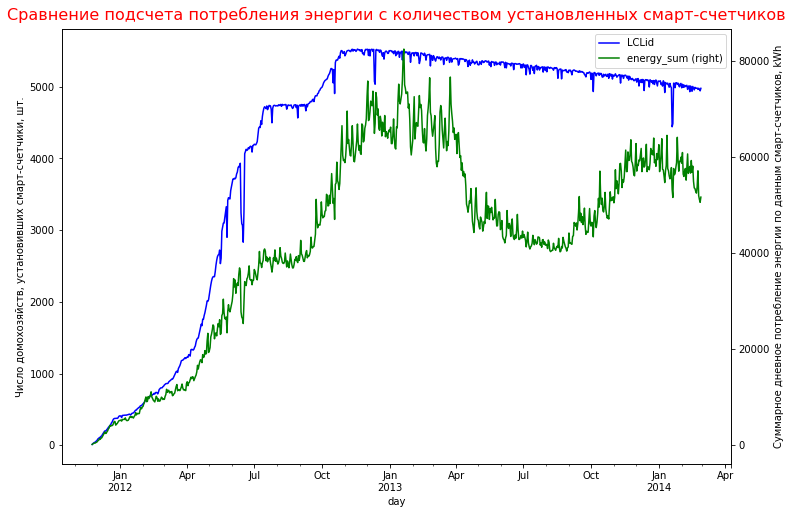

In [26]:
fig,ax=plt.subplots(figsize=(12,8))
#data_hh_counter_power.LCLid.plot(ax=ax);
#data_hh_counter_power.energy_sum.plot(secondary_y=True, style='g');
data_hh_counter_power.plot(ax=ax, secondary_y=['energy_sum'], style=['b','g'])
ax.set_ylabel('Число домохозяйств, установивших смарт-счетчики, шт.')
ax.right_ax.set_ylabel('Суммарное дневное потребление энергии по данным смарт-счетчиков, kWh');
ax.set_title('Сравнение подсчета потребления энергии с количеством установленных смарт-счетчиков', color = 'red', size = 16, verticalalignment='bottom');


##### По построенному графику видно, что на начальном этапе потребление энергии зависит только от роста числа счетчиков, при этом, например, сезонный фактор не просматривается. Этот временной этап, очевидно, соответствует периоду установки счетчиков и наладке системы (с 11.2011 до, примерно, 09.2012). Данные за этот период надо также исключить из рассмотрения.

### 2.5 Определим временной интервал (окно), который будем считать достаточным для построения выборки наблюдений
Статистически состоятельным (достаточным) можно считать период наблюдений, охватывающий все сезонные колебания погодных условий, и другие циклически повторяющиеся факторы, которые влияют на потребление электроэнергии. Логично, что за такой период можно принять один календарный год. Из всей выборки для этих целей лучше всего подходят данные за 2013 год, как наиболее полные, т.к измерения по остальным годам либо представлены не полно (11.2011 - 09.2012), либо не всеми сезонами и месяцами (2011, 2014).

In [27]:
begin_date = datetime.datetime(2013, 1,   1)
end_date   = datetime.datetime(2013, 12, 31)

data_daily_window = data_daily[(data_daily['energy_count'] == 48) & (data_daily['day'] >= begin_date) &  (data_daily['day'] <= end_date)].dropna()
data_daily_window.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
383,MAC000131,2013-01-01,0.1595,0.317208,0.899,48,0.268927,15.226,0.065
384,MAC000131,2013-01-02,0.1315,0.249750,0.831,48,0.250353,11.988,0.064
385,MAC000131,2013-01-03,0.1165,0.229208,0.783,48,0.230147,11.002,0.065
386,MAC000131,2013-01-04,0.1250,0.238458,0.821,48,0.248757,11.446,0.060
387,MAC000131,2013-01-05,0.1395,0.158375,0.784,48,0.121843,7.602,0.061


In [28]:
len(data_daily_window.groupby('LCLid'))

5528

В результате только сужения периода (полных) наблюдений (окна наблюдений) до одного 2013 года, количество домохозяйств в наборе данных уменьшилось до 5528 (т.е. мы "потеряли" 38 домохозяйств)

### 2.6 Исключим из рассмотрения домохозяйства, для которых количество дней наблюдений (сбора данных) в 2013 году существенно меньше, чем количество дней в году 
Предположим, что достаточным периодом наблюдений является количество рабочих и выходных дней в году (за исключением праздничных выходных дней - ипользуем данные файла *uk_bank_holidays.csv*).

In [29]:
data_uk_bank_holidays['Bank holidays'] = pd.to_datetime(data_uk_bank_holidays['Bank holidays'])
work_period = 365 - len(data_uk_bank_holidays[(data_uk_bank_holidays['Bank holidays'] >= begin_date) &  (data_uk_bank_holidays['Bank holidays'] <= end_date)])
work_period

357

Таким образом, мы получили 8 праздничных дней, и, соотвественно, достаточный период наблюдений составит 357 дней. 

Проверим нашу гипотезу о влиянии праздничных дней на период наблюдений. Ранжируем все дни года, по увеличению количества домохозяйств, участвующих в измерении потребления энергии. Если наша гипотеза верна, то первыми (с наименьшими данными) будут праздничные дни.

In [30]:
data_daily_window.groupby('day').count().sort_values(by='LCLid', ascending=True).head(15)

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
day,,,,,,,,
2013-10-04,4933,4933,4933,4933,4933,4933,4933,4933
2013-12-12,4947,4947,4947,4947,4947,4947,4947,4947
2013-12-19,4996,4996,4996,4996,4996,4996,4996,4996
2013-12-05,5010,5010,5010,5010,5010,5010,5010,5010
2013-12-30,5011,5011,5011,5011,5011,5011,5011,5011
2013-12-26,5032,5032,5032,5032,5032,5032,5032,5032
2013-12-24,5041,5041,5041,5041,5041,5041,5041,5041
2013-11-10,5051,5051,5051,5051,5051,5051,5051,5051
2013-12-29,5055,5055,5055,5055,5055,5055,5055,5055


Мы видим, что дни с наименьшим количеством наблюдений не соотвествуют праздничным дням. Следовательно наше предположение, что достаточным периодом наблюдений может являться количество дней в году за исключением праздничных - неверно.

Применим другой метод оценки. Построим гистограмму распределения по времени (по числу дней, в которые проводились измерения) количества домохозяйств, участвующих в измерениях.

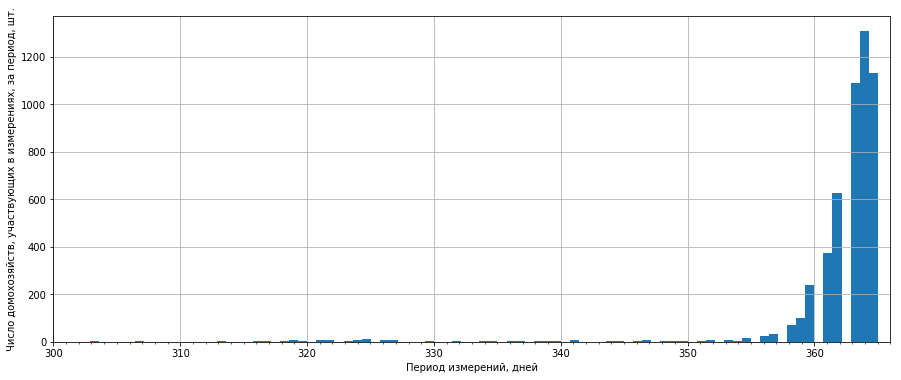

In [31]:
data_work_period = data_daily_window.groupby('LCLid').count()
fig,ax=plt.subplots(figsize=(15,6))
plt.xlim(300, 366)
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
data_work_period['day'].hist(ax=ax, bins = 500);
ax.set_xlabel('Период измерений, дней');
ax.set_ylabel('Число домохозяйств, участвующих в измерениях, за период, шт.');

#### Вывод: 
###### большинство домохозяйств в 2013 году имели период наблюдений (период измерений потребления электричества)  от 358 до 365 дней. Интересно, что этот результат численно совпал с нашим предыдущим предположением (о достаточности периода, состоящего из всех дней в году за исключением праздничных).

Посчитаем, сколько всего домохозяйств в 2013 году, которые потребляли электроэнергию больше чем work_period (357) дней. Запомним список этих домохозяйств в переменной **list_hh_work_period**

In [32]:
list_hh_work_period = data_work_period[data_work_period['day'] > work_period].index
len(list_hh_work_period)

4934

Получили, что от исходного числа домохозяйств (5566) для дальнейшего анализа мы можем оставить только 4934 из них.
Посчитаем, сколько всего домохозяйств в 2013 году, которые потребляли электроэнергию work_period (357) и меньше дней

In [33]:
len(data_work_period[data_work_period['day'] <= work_period])

594

### 2.7 Приведем в порядок все рассматриваемые наборы данных (удалим "лишние" подмножества) в соответствии с установленными нами окнами наблюдений

Найдем пересечение списков *list_hh_NP_less* и *list_hh_work_period*. При необходимости можем уменьшить выборку домохозяйств до заданного % (<=100%). Это будем окончательный (рабочий) перечень домохозяйств, которые оставляем для дальнейшего анализа электропотребления. Запомним его в переменной **list_hh_work**

In [34]:
data_groups = data_informations_households[data_informations_households['Acorn_grouped']!='NP-Household'].groupby('Acorn_grouped').count()
data_groups.index

Index(['Adversity', 'Affluent', 'Comfortable', 'Rising', 'Stretched'], dtype='object', name='Acorn_grouped')

In [35]:
def prepare_list_hh(list_hh_summary, list_groups, percent):
    '''
    функция prepare_list_hh(list_hh_summary, percent)
    возвращает от перечня домохозяйств заданного в list_hh_summary 
    выбранную случайным образом выборку длиной percent
    в каждой Acorn_grouped из list_groups 
    
    в качестве аргументов получает
        - list_hh_summary - список домовладений (состоящих в разных Acorn_grouped)
        - list_groups - список групп (Acorn_grouped)
        - percent - % выборки
    '''
    print('All Acorn_group summary: {}'.format(len(list_hh_summary)))
    if percent >= 100:
        return list_hh_summary
    list_hh_work = set()
    for group in list_groups:
        list_current = data_informations_households[(data_informations_households['Acorn_grouped'] == group) & data_informations_households['LCLid'].isin(list_hh_summary)].sample(frac = percent/100)['LCLid'].unique()
        print('Acorn_group: {}, summary: {}, {}%: {}'.format(group, data_groups.loc[group]['LCLid'], percent, len(list_current)))
        list_hh_work = list_hh_work | set(list_current)
    return list_hh_work

##### Для дальнейшего анализа возьмем 10% от всей выборки

In [36]:
list_hh_work = prepare_list_hh(set(list_hh_NP_less) & set(list_hh_work_period), data_groups.index, 10)
print('\nИтого, количество домовладений в полученной выборке: {}'.format(len(list_hh_work)))

All Acorn_group summary: 4893
Acorn_group: Adversity, summary: 1044, 10%: 92
Acorn_group: Affluent, summary: 333, 10%: 30
Acorn_group: Comfortable, summary: 1507, 10%: 137
Acorn_group: Rising, summary: 1859, 10%: 161
Acorn_group: Stretched, summary: 772, 10%: 70

Итого, количество домовладений в полученной выборке: 490


Сформируем рабочую выборку для набора данных *data_daily*

In [37]:
data_daily_work_window = data_daily_window[data_daily_window['LCLid'].isin(list_hh_work)]
len(data_daily_work_window.groupby('LCLid').count())

490

Посчитаем общее число измерений смарт-счетчиков всех домохозяйств в рабочей выборке *data_daily_work_window*

In [38]:
len(data_daily_work_window)

177940

Сформируем рабочую выборку для набора данных *data_weather_daily_darksky*. 
Из-за ошибки в наборе данных *data_weather_daily_darksky* (по индексу ***'time'*** отсутствует дата 2013-10-27, при этом дата 2013-03-31 задвоена) предлагается в качестве индекса ***'time'***  использовать ***'sunriseTime'*** обрезав время. 

In [39]:
#data_weather_daily_darksky['time'] = data_weather_daily_darksky['sunriseTime'].apply(lambda time: pd.to_datetime(pd.to_datetime(time).date()))
data_weather_daily_darksky['time'] = pd.to_datetime(pd.to_datetime(data_weather_daily_darksky['sunriseTime']).dt.date)
data_weather_daily_work_window = data_weather_daily_darksky[(data_weather_daily_darksky['time'] >= begin_date) &  (data_weather_daily_darksky['time'] <= end_date)].dropna()
len(data_weather_daily_work_window)

365

Сформируем рабочую выборку для набора данных *data_weather_hourly_darksky*

In [40]:
data_weather_hourly_darksky['time'] = pd.to_datetime(data_weather_hourly_darksky['time'])
#data_weather_hourly_darksky['day'] = data_weather_hourly_darksky['time'].apply(lambda time: pd.to_datetime(time.date()))
data_weather_hourly_darksky['day'] = pd.to_datetime(data_weather_hourly_darksky['time'].dt.date)
data_weather_hourly_work_window = data_weather_hourly_darksky[(data_weather_hourly_darksky['time'] >= begin_date) &  (data_weather_hourly_darksky['time'] <= end_date)].dropna()


In [41]:
len(data_weather_hourly_work_window.groupby('day').count())

365

Сформируем рабочую выборку для набора данных *hhblock_dataset\blockXX*

In [42]:
list_blocks = data_informations_households[data_informations_households['LCLid'].isin(list_hh_work)]['file'].unique()
len(list_blocks)

110

Для формирования данной выборки необходимо обработать часть файлов (из 112)

In [43]:

data_hh_block_all = pd.DataFrame()
with tqdm(total=len(list_blocks), file = sys.stdout) as pbar:
    for i,block_name in enumerate(list_blocks):
        file_block = block_name+'.csv'
        data_hh_block = pd.read_csv(os.path.join(data_dir, hhblock_dir, file_block), encoding = 'ANSI')
        data_hh_block['day'] = pd.to_datetime(data_hh_block['day'])
        data_hh_block = data_hh_block[(data_hh_block['day'] >= begin_date) &  (data_hh_block['day'] <= end_date)]    
        data_hh_block_all = pd.concat([data_hh_block_all, data_hh_block[data_hh_block['LCLid'].isin(list_hh_work)]], axis = 0)
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(1)
        #sleep(1)
pbar.close()

processed: 110: 100%|████████████████████████| 110/110 [07:16<00:00,  4.63s/it]


In [44]:
#data_hh_block_all = pd.DataFrame()
#for block_name in tqdm(list_blocks):
#    file_block = block_name+'.csv'
#    data_hh_block = pd.read_csv(os.path.join(data_dir, hhblock_dir, file_block), encoding = 'ANSI')
#    data_hh_block['day'] = pd.to_datetime(data_hh_block['day'])
#    data_hh_block = data_hh_block[(data_hh_block['day'] >= begin_date) &  (data_hh_block['day'] <= end_date)]    
#    data_hh_block_all = pd.concat([data_hh_block_all, data_hh_block[data_hh_block['LCLid'].isin(list_hh_work)]], axis = 0)

In [45]:
data_hh_block_all.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
10345,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,1.311,1.283,1.288,1.160,1.314,0.916,0.719,0.656,0.590,0.559
10346,MAC003566,2013-01-02,0.535,0.595,0.521,0.511,0.585,0.589,0.567,0.565,...,1.510,1.123,1.125,1.225,1.223,1.188,1.270,0.887,1.273,0.981
10347,MAC003566,2013-01-03,1.070,0.559,0.528,0.611,0.533,0.560,0.567,0.539,...,1.288,1.298,1.294,1.191,1.165,1.259,1.420,0.868,0.784,0.715
10348,MAC003566,2013-01-04,0.614,0.562,0.614,0.612,0.630,0.618,0.616,0.557,...,1.048,1.137,1.222,1.571,1.346,1.255,1.120,1.052,0.637,0.659
10349,MAC003566,2013-01-05,0.634,0.604,0.679,0.601,0.657,0.621,0.646,0.625,...,0.523,0.481,0.517,0.471,0.501,0.483,0.801,0.702,0.603,0.544


In [46]:
len(data_hh_block_all)

177940

##### Общее число измерений смарт-счетчиков всех домохозяйств в рабочей выборке для hhblock_dataset\blockXX совпало с аналогичным для data_daily_work_window. Это факт подтверждает, что мы корректно селектировали одни теже домохозяйства и периоды наблюдений для обоих наборов данных

In [47]:
midnight = datetime.datetime(2013, 1,1, 0,0)
print(midnight)

2013-01-01 00:00:00


In [48]:
#columns =['{}'.format((midnight + datetime.timedelta(minutes=i*30)).strftime('%H:%M')) for i in range(1,49)]
columns = [((midnight + datetime.timedelta(minutes=i*30)).time()) for i in range(1,49)]
columns.insert(0, 'day')
columns.insert(0, 'LCLid')
print(columns)

['LCLid', 'day', datetime.time(0, 30), datetime.time(1, 0), datetime.time(1, 30), datetime.time(2, 0), datetime.time(2, 30), datetime.time(3, 0), datetime.time(3, 30), datetime.time(4, 0), datetime.time(4, 30), datetime.time(5, 0), datetime.time(5, 30), datetime.time(6, 0), datetime.time(6, 30), datetime.time(7, 0), datetime.time(7, 30), datetime.time(8, 0), datetime.time(8, 30), datetime.time(9, 0), datetime.time(9, 30), datetime.time(10, 0), datetime.time(10, 30), datetime.time(11, 0), datetime.time(11, 30), datetime.time(12, 0), datetime.time(12, 30), datetime.time(13, 0), datetime.time(13, 30), datetime.time(14, 0), datetime.time(14, 30), datetime.time(15, 0), datetime.time(15, 30), datetime.time(16, 0), datetime.time(16, 30), datetime.time(17, 0), datetime.time(17, 30), datetime.time(18, 0), datetime.time(18, 30), datetime.time(19, 0), datetime.time(19, 30), datetime.time(20, 0), datetime.time(20, 30), datetime.time(21, 0), datetime.time(21, 30), datetime.time(22, 0), datetime.tim

In [49]:
data_hh_block_all.columns = columns
data_hh_block_all.head()

,LCLid,day,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,...,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00,00:00:00
10345,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,1.311,1.283,1.288,1.160,1.314,0.916,0.719,0.656,0.590,0.559
10346,MAC003566,2013-01-02,0.535,0.595,0.521,0.511,0.585,0.589,0.567,0.565,...,1.510,1.123,1.125,1.225,1.223,1.188,1.270,0.887,1.273,0.981
10347,MAC003566,2013-01-03,1.070,0.559,0.528,0.611,0.533,0.560,0.567,0.539,...,1.288,1.298,1.294,1.191,1.165,1.259,1.420,0.868,0.784,0.715
10348,MAC003566,2013-01-04,0.614,0.562,0.614,0.612,0.630,0.618,0.616,0.557,...,1.048,1.137,1.222,1.571,1.346,1.255,1.120,1.052,0.637,0.659
10349,MAC003566,2013-01-05,0.634,0.604,0.679,0.601,0.657,0.621,0.646,0.625,...,0.523,0.481,0.517,0.471,0.501,0.483,0.801,0.702,0.603,0.544


#### Наборы данных сформированы:
- **list_hh_work** - (рабочий) перечень домохозяйств, которые оставляем для дальнейшего анализа электропотребления
- **data_daily_work_window** - выборка для набора данных *data_daily* (суточное энергопотребление каждого домохозяйства из *list_hh_work* в интервале 2013.01.01 - 2013.12.31)
- **data_weather_daily_work_window** - выборка для набора данных *data_weather_daily_darksky* (на интервале 2013.01.01 - 2013.12.31)
- **data_weather_hourly_work_window** - выборка для набора данных *data_weather_hourly_darksky* (на интервале 2013.01.01 - 2013.12.31)
- **data_hh_block_all** - выборка для набора данных *hhblock_dataset\blockXX* (данные о получасовом энергопотребление каждого домохозяйства из *list_hh_work* в каждые сутки в интервале 2013.01.01 - 2013.12.31)

# 3. Анализ энергопотребления

### 3.1 Произведем анализ зависимости суммарного потребления энергии от среднесуточной температуры. Найдем средний прирост потребления энергии при изменении температуры

#### 3.1.1 Построим график зависимости суммарного потребления энергии и среднесуточной температуры от времени

Сформируем набор данных **data_daily_energy** включающий суммарное потребление энергии.

In [50]:
data_daily_energy = data_daily_work_window.groupby(['day']).agg({'energy_sum': 'sum'}).reset_index()
data_daily_energy.head()

,day,energy_sum
0,2013-01-01,5906.509001
1,2013-01-02,5870.341001
2,2013-01-03,5665.001997
3,2013-01-04,5582.588000
4,2013-01-05,5711.870998


Сформируем набор данных **data_weather_d** включающий информацию о среднедневной температуре.

In [51]:
data_weather_d=pd.DataFrame()
data_weather_d['day']=data_weather_daily_work_window['time']
data_weather_d['temperature_mean']=(data_weather_daily_work_window['temperatureMax']+data_weather_daily_work_window['temperatureMin'])/2
data_weather_d.head()

,day,temperature_mean
427,2013-09-24,16.500
428,2013-07-26,20.725
429,2013-07-09,18.810
430,2013-08-08,17.820
431,2013-01-11,3.295


Объединим наборы данных *data_daily_energy* и *data_weather_d*.

In [52]:
data_daily_energy = data_daily_energy.merge(data_weather_d, on=['day'],how='inner')
data_daily_energy.head()

,day,energy_sum,temperature_mean
0,2013-01-01,5906.509001,5.400
1,2013-01-02,5870.341001,7.065
2,2013-01-03,5665.001997,10.530
3,2013-01-04,5582.588000,9.480
4,2013-01-05,5711.870998,9.250


In [53]:
def time_unix_2(row):
    '''
    Функция time_unix_2(row) переводит дату в Unix формат
    '''
    return time.mktime(pd.to_datetime(row['day']).timetuple())

Добавим в набор данных *data_daily_energy* информацию о дате в  Unix формате.

In [54]:
data_daily_energy['month'] = data_daily_energy.apply(lambda t: time_unix_2(t),axis=1)
data_daily_energy.head()

,day,energy_sum,temperature_mean,month
0,2013-01-01,5906.509001,5.400,1.356984e+09
1,2013-01-02,5870.341001,7.065,1.357070e+09
2,2013-01-03,5665.001997,10.530,1.357157e+09
3,2013-01-04,5582.588000,9.480,1.357243e+09
4,2013-01-05,5711.870998,9.250,1.357330e+09


Сформируем список **locations**, который содержит временные метки начала месяцев в Unix формате.

In [55]:
locations=[]
locations=(data_daily_energy['month'][(pd.to_datetime(data_daily_energy['day']).dt.day==1)].values.tolist())
locations

[1356984000.0,
 1359662400.0,
 1362081600.0,
 1364760000.0,
 1367352000.0,
 1370030400.0,
 1372622400.0,
 1375300800.0,
 1377979200.0,
 1380571200.0,
 1383249600.0,
 1385841600.0]

Построим графики зависимости суммарного потребления энергии и среднесуточной температуры от времени.

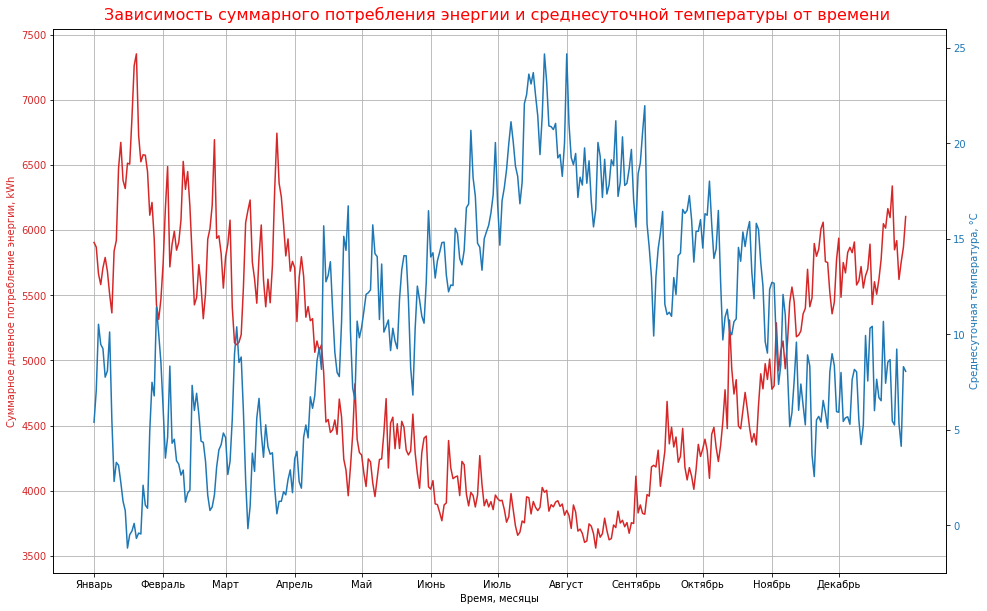

In [56]:
fig,ax=plt.subplots(figsize=(16,10))
plt.xticks(locations,('Январь', 'Февраль', 'Март', 'Апрель', 'Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь'))
color = 'tab:red'
color_2 = 'tab:blue'
ax.set_title('Зависимость суммарного потребления энергии и среднесуточной температуры от времени ', color = 'red', size = 16, verticalalignment='bottom');
ax_2 = ax.twinx()
ax.plot(data_daily_energy['month'],data_daily_energy['energy_sum'],color=color)
ax_2.plot(data_daily_energy['month'],data_daily_energy['temperature_mean'],color=color_2)
ax_2.set_ylabel('Среднесуточная температура, \N{DEGREE SIGN}С',color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)
ax.set_ylabel('Суммарное дневное потребление энергии, kWh', color=color)
ax.set_xlabel('Время, месяцы')
ax.tick_params(axis='y', labelcolor=color)
ax.grid(which='major')
#plt.grid(True)

#### На полученном графике хорошо видно, что:

*кривые зависимости температур от времени года и потребленной электроэнергии от времени года практически зеркальны (по отношению друг другу) относительно оси, проходящей через ординату 10 градусов (по Цельсию) и находятся в явной связи. Исключение составляет отрезок, соответствующий периоду времени с июня по сентябрь.*

#### 3.1.2 Расчитаем средний прирост потребления энергии при изменении среднедневной температуры на 1 градус Цельсия

Выберем диапазоны даных для рассчета показателей среднего прироста потребления энергии :
- с Апреля по Июнь, для расчета среднего прироста потребления энергии при повышении температуры,
- с Сентября по Ноябрь, для расчета среднего прироста потребления энергии при понижении температуры.

In [57]:
def prirost(begin_date,end_date):
    '''
    Функция prirost(begin_date,end_date) вычисляет средний прирост потребления энергии в указанном диапазоне дат. 
    Даты задаются в виде строки в формате 'Год-Месяц-День'
    
    Функция возвращает вычисленное значение прироста (в виде числа float)
    В качестве аргументов функция получает
        begin_date - начальная дата в диапазоне
        end_date - финальная дата в диапазоне
    '''
    begin_date = datetime.datetime.strptime(begin_date, '%Y-%m-%d')
    end_date   = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    data_daily_growth = data_daily_energy[(data_daily_energy['day'] >= begin_date) &  (data_daily_energy['day'] <= end_date)].dropna()
    avg_temp=(data_daily_growth['temperature_mean'].max()-data_daily_growth['temperature_mean'].min())
    min_eng=data_daily_growth['energy_sum'].min()
    max_eng=data_daily_growth['energy_sum'].max()
    t_mean=round((math.pow((max_eng/min_eng),1/(avg_temp-1))*100)-100,2)
    return t_mean

Cредний прирост потребления энергии при увеличении среднедневной температуры на 1 градус цельсия, %.

In [58]:
prirost('2013-04-01','2013-06-30')

2.46

Cредний прирост потребления энергии при уменьшении среднедневной температуры на 1 градус цельсия, %.

In [59]:
prirost('2013-09-01','2013-11-30')

2.54

#### Вывод:
*Совпадение (с точностью до погрешности) скорости изменения электропотребления при сезонном росте и понижении уличных температур позволяет нам сделать вывод не просто о связи эти двух величин, но и об их прямой зависимости. Далее мы еще вернемся к более подробному изучению этой зависимости и построим математическую модель, связывающую температурные изменения и потребление электроэнергии.*

### 3.2 Сделаем сравнение потребления энергии в выходные/праздничные и рабочие дни

Сформируем набор данных **data_daily_Acorn_grouped** из двух таблиц.

In [60]:
data_daily_Acorn_grouped = data_daily_work_window.merge(data_informations_households, on = 'LCLid', how = 'left')
data_daily_Acorn_grouped.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,file,block_name
0,MAC000234,2013-01-01,0.1240,0.149500,0.390,48,0.101889,7.176,0.033,Std,ACORN-E,Rising,block_22,block_022
1,MAC000234,2013-01-02,0.1890,0.229417,0.524,48,0.119337,11.012,0.044,Std,ACORN-E,Rising,block_22,block_022
2,MAC000234,2013-01-03,0.1815,0.341854,1.923,48,0.419854,16.409,0.033,Std,ACORN-E,Rising,block_22,block_022
3,MAC000234,2013-01-04,0.3115,0.422458,1.440,48,0.359611,20.278,0.068,Std,ACORN-E,Rising,block_22,block_022
4,MAC000234,2013-01-05,0.1980,0.244062,0.590,48,0.153197,11.715,0.033,Std,ACORN-E,Rising,block_22,block_022


Сформируем набор данных **data_daily_grouped** включающий информацию о суммарном потреблении энергии, количестве домохозяйств.

In [61]:
data_daily_grouped = data_daily_Acorn_grouped[['day','energy_sum','Acorn_grouped','LCLid']].groupby(['day', 'Acorn_grouped']).agg({'energy_sum':'sum','LCLid':'count'}).reset_index()
data_daily_grouped.head()

,day,Acorn_grouped,energy_sum,LCLid
0,2013-01-01,Adversity,856.583000,92
1,2013-01-01,Affluent,491.853000,30
2,2013-01-01,Comfortable,1462.789000,137
3,2013-01-01,Rising,2145.050000,161
4,2013-01-01,Stretched,950.234001,70


In [62]:
def holiday(day):
    '''
    Функция holiday(day) для дня day определяет является ли он выходным/праздничным или рабочим
    
    Функция возвращает 1, если день является выходным/праздничным
                    и  0, если день является рабочим
    В качестве аргументов функция получает
        day - дата в формате datetime                    
    '''
    if np.any(day == data_uk_bank_holidays['Bank holidays']):
        return 1
    if int(day.weekday())>4 :
        return 1
    return 0

Внесем в набор данных *data_daily_grouped* информацию о будних, выходных днях.

In [63]:
data_daily_grouped['holiday'] = data_daily_grouped['day'].apply(lambda x: holiday(x))
data_daily_grouped['workday'] = (data_daily_grouped['holiday']+1)%2
data_daily_grouped.head()

,day,Acorn_grouped,energy_sum,LCLid,holiday,workday
0,2013-01-01,Adversity,856.583000,92,1,0
1,2013-01-01,Affluent,491.853000,30,1,0
2,2013-01-01,Comfortable,1462.789000,137,1,0
3,2013-01-01,Rising,2145.050000,161,1,0
4,2013-01-01,Stretched,950.234001,70,1,0


Добавим в набор данных *data_daily_grouped* информацию о потреблении энергии по категориям будний/выходной день.

In [64]:
data_daily_grouped['workday_all']=data_daily_grouped['energy_sum']*data_daily_grouped['workday']
data_daily_grouped['holiday_all']=data_daily_grouped['energy_sum']*data_daily_grouped['holiday']
data_daily_grouped['workday_house']=data_daily_grouped['workday_all']/data_daily_grouped['LCLid']
data_daily_grouped['holiday_house']=data_daily_grouped['holiday_all']/data_daily_grouped['LCLid']
data_daily_grouped.head()

,day,Acorn_grouped,energy_sum,LCLid,holiday,workday,workday_all,holiday_all,workday_house,holiday_house
0,2013-01-01,Adversity,856.583000,92,1,0,0.0,856.583000,0.0,9.310685
1,2013-01-01,Affluent,491.853000,30,1,0,0.0,491.853000,0.0,16.395100
2,2013-01-01,Comfortable,1462.789000,137,1,0,0.0,1462.789000,0.0,10.677292
3,2013-01-01,Rising,2145.050000,161,1,0,0.0,2145.050000,0.0,13.323292
4,2013-01-01,Stretched,950.234001,70,1,0,0.0,950.234001,0.0,13.574771


Сформируем набор данных **for_plot_mean_workweek** включающий информацию о потребленной энергии в будние/выходные дни по группам потребителей.

In [65]:
for_plot_mean_workweek=data_daily_grouped.groupby(['Acorn_grouped']).sum().reset_index()
for_plot_mean_workweek.head(10)

,Acorn_grouped,energy_sum,LCLid,holiday,workday,workday_all,holiday_all,workday_house,holiday_house
0,Adversity,251690.455987,33377,112,253,172182.120988,79508.334999,1883.703172,869.030069
1,Affluent,126498.133002,10890,112,253,86314.752996,40183.380006,2898.544252,1341.983384
2,Comfortable,463090.598991,49763,112,253,314497.884989,148592.714002,2307.438146,1089.345652
3,Rising,661014.459978,58462,112,253,456732.872981,204281.586997,2852.949981,1274.355986
4,Stretched,277600.143986,25448,112,253,189247.994994,88352.148993,2715.425730,1265.727167


Добавим в набор данных *for_plot_mean_workweek* столбцы для построения гистограмм: суммарная средняя потребленная энергия в будние/выходные дни, средняя потребленная энергия на 1 домохозяйство в будние/выходные дни.

In [66]:
for_plot_mean_workweek['workday_all']=for_plot_mean_workweek['workday_all']/for_plot_mean_workweek['workday']
for_plot_mean_workweek['holiday_all']=for_plot_mean_workweek['holiday_all']/for_plot_mean_workweek['holiday']
for_plot_mean_workweek['workday_house']=for_plot_mean_workweek['workday_house']/for_plot_mean_workweek['workday']
for_plot_mean_workweek['holiday_house']=for_plot_mean_workweek['holiday_house']/for_plot_mean_workweek['holiday']
for_plot_mean_workweek.drop(columns = ['energy_sum','LCLid','holiday','workday'], inplace=True)
for_plot_mean_workweek.head()

,Acorn_grouped,workday_all,holiday_all,workday_house,holiday_house
0,Adversity,680.561743,709.895848,7.445467,7.759197
1,Affluent,341.165032,358.780179,11.456697,11.981995
2,Comfortable,1243.074644,1326.720661,9.120309,9.726300
3,Rising,1805.268273,1823.942741,11.276482,11.378178
4,Stretched,748.015790,788.858473,10.732908,11.301135


Построим гистограммы суммарного потребления по каждой из групп потребителей.

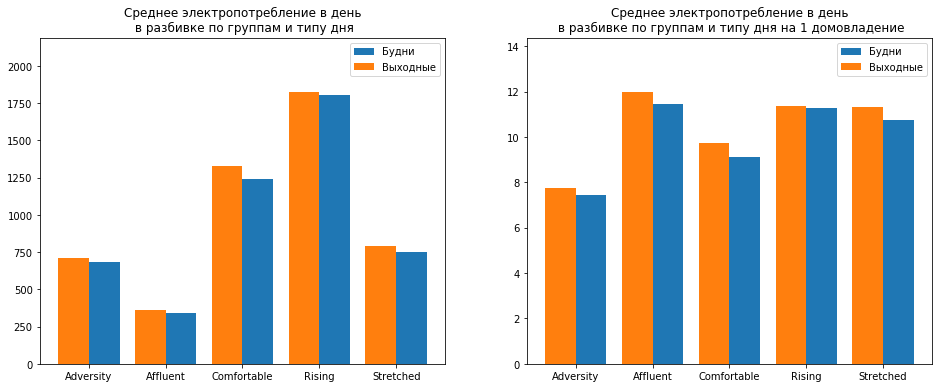

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].set_title('Среднее электропотребление в день\n в разбивке по группам и типу дня')
axes[0].bar(x=for_plot_mean_workweek['Acorn_grouped'],height = for_plot_mean_workweek['workday_all'], width = 0.4, align = 'edge', label = 'Будни')
axes[0].bar(x=for_plot_mean_workweek['Acorn_grouped'],height = for_plot_mean_workweek['holiday_all'], width = -0.4, align = 'edge', label = 'Выходные')
axes[0].legend(loc = 1)
axes[0].set_ylim(0, for_plot_mean_workweek['holiday_all'].max()+for_plot_mean_workweek['holiday_all'].max()*0.2)
axes[1].set_title('Среднее электропотребление в день\n в разбивке по группам и типу дня на 1 домовладение')
axes[1].bar(x=for_plot_mean_workweek['Acorn_grouped'],height = for_plot_mean_workweek['workday_house'], width = 0.4, align = 'edge', label = 'Будни')
axes[1].bar(x=for_plot_mean_workweek['Acorn_grouped'],height = for_plot_mean_workweek['holiday_house'], width = -0.4, align = 'edge', label = 'Выходные')
axes[1].legend(loc = 1);
axes[1].set_ylim(0, for_plot_mean_workweek['holiday_house'].max()+for_plot_mean_workweek['holiday_house'].max()*0.2);


##### На представленных графиках видно, что:
- *общее энергопотребление (и в выходные и в рабочие дни), главным образом, зависит от числа домовладений в каждой из групп, в представленной выборке*
- *энергопотребление в выходные дни превышает энергопотребление в рабочие дни*
- *в ранжировании энергопотребления в расчете на одно домовладение с большим отрывом вырывается вперед самая обеспеченная часть. Далее, практически "вровень", идут средний класс и, также, с отрывом, но в вниз, наименнее обеспеченные.*


Для каждой группы потребителей найдем прирост среднесуточного потребления энергии в рабочие дни к потреблению в выходные дни.

In [68]:
for_plot_mean_workweek['att']=round(((for_plot_mean_workweek['holiday_house']-for_plot_mean_workweek['workday_house'])/for_plot_mean_workweek['holiday_house'])*100,2)
for_plot_mean_workweek.sort_values(by='att', inplace = True)
for_plot_mean_workweek.head(10)

,Acorn_grouped,workday_all,holiday_all,workday_house,holiday_house,att
3,Rising,1805.268273,1823.942741,11.276482,11.378178,0.89
0,Adversity,680.561743,709.895848,7.445467,7.759197,4.04
1,Affluent,341.165032,358.780179,11.456697,11.981995,4.38
4,Stretched,748.015790,788.858473,10.732908,11.301135,5.03
2,Comfortable,1243.074644,1326.720661,9.120309,9.726300,6.23


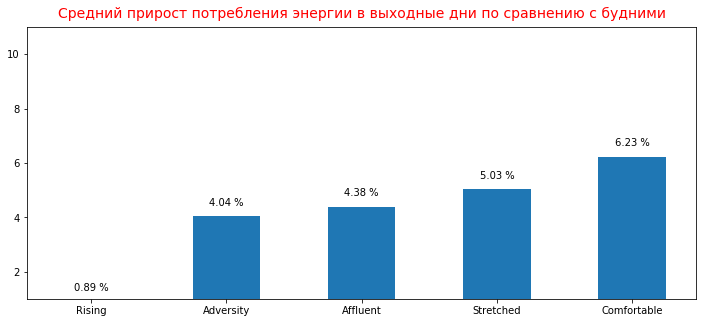

In [69]:
fig, axes = plt.subplots(figsize=(12,5))
axes.set_title('Средний прирост потребления энергии в выходные дни по сравнению с будними', color = 'red', size = 14, verticalalignment='bottom')
axes.bar(x=for_plot_mean_workweek['Acorn_grouped'],height = for_plot_mean_workweek['att'],width = 0.5,  label = 'Будни')
axes.set_ylim(1, 11)
rects = axes.patches
labels = for_plot_mean_workweek['att']
for label, rect in zip(labels, rects):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width() / 2, height+0.4, str(label)+' %',ha='center', va='baseline')


##### Общий вывод по данной части:
- *потребление электроэнергии в выходные дни возрастает, по сравнению с будними днями*
- *наименьший прирост потребления электроэнергии в выходные дни наблюдается в обеспеченной группе. При этом явно не прослеживается зависимость величины прироста от финансового благополучия.*


### 3.3 Для каждой из пяти групп потребителей проведем анализ суточного энергопотребления в течении 2013 года
- суммарно на группу и в пересчете на одно домохозяйство с учетом светового дня 

- отдельно по тарифным группам: 
    - **T1** - пиковая нагрузка, 
    - **T2** - средняя нагрузка, 
    - **T3** - низкая нагрузка, 

Сделаем выводы о периодах суток с наибольшим энергопотреблением, и о влиянии на энергопотреблением выбранного тарифа в каждой из пяти групп.

Определим константы для T1, T2, T3, в соответствии с общепринятой практикой:
- T1 - с 07:00 до 10:00 и с 17:00 до 21:00, 
- T2 - с 10:00 до 17:00 и с 21:00 до 23:00,
- T3 - с 23:00 до 24:00 и с 00:00 до 07:00

In [70]:
T1_default = [[datetime.timedelta(hours=7, minutes=0),  datetime.timedelta(hours=9, minutes=59)],
              [datetime.timedelta(hours=17, minutes=0), datetime.timedelta(hours=20, minutes=59)]]
T2_default = [[datetime.timedelta(hours=10, minutes=0), datetime.timedelta(hours=16, minutes=59)],
              [datetime.timedelta(hours=21, minutes=0), datetime.timedelta(hours=22, minutes=59)]]
T3_default = [[datetime.timedelta(hours=0, minutes=0),  datetime.timedelta(hours=6, minutes=59)],
              [datetime.timedelta(hours=23, minutes=0), datetime.timedelta(hours=23, minutes=59)]]

In [71]:
(T1_default, T2_default, T3_default)

([[datetime.timedelta(seconds=25200), datetime.timedelta(seconds=35940)],
  [datetime.timedelta(seconds=61200), datetime.timedelta(seconds=75540)]],
 [[datetime.timedelta(seconds=36000), datetime.timedelta(seconds=61140)],
  [datetime.timedelta(seconds=75600), datetime.timedelta(seconds=82740)]],
 [[datetime.timedelta(0), datetime.timedelta(seconds=25140)],
  [datetime.timedelta(seconds=82800), datetime.timedelta(seconds=86340)]])

Добавим в набор *data_hh_block_all* данные о времени восхода и заката солнца -> **data_hh_block_all_sun**

In [72]:
data_sun = data_weather_daily_work_window[['time', 'sunriseTime', 'sunsetTime']].rename(columns = {'time': 'day'})
data_hh_block_all['day'] = data_hh_block_all['day'].apply(lambda day: pd.to_datetime(day.date()))
data_hh_block_all_sun = data_hh_block_all.merge(data_sun, on='day')
data_hh_block_all_sun.head()

,LCLid,day,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,...,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00,00:00:00,sunriseTime,sunsetTime
0,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,1.288,1.160,1.314,0.916,0.719,0.656,0.590,0.559,2013-01-01 08:07:21,2013-01-01 16:03:05
1,MAC003863,2013-01-01,0.751,0.954,0.728,0.739,0.671,0.705,0.654,0.715,...,1.220,0.821,1.308,1.195,0.703,0.710,0.632,0.247,2013-01-01 08:07:21,2013-01-01 16:03:05
2,MAC000850,2013-01-01,0.525,0.586,0.360,0.220,0.289,0.230,0.255,0.135,...,0.417,0.486,0.556,0.340,0.389,0.305,0.322,0.294,2013-01-01 08:07:21,2013-01-01 16:03:05
3,MAC001528,2013-01-01,0.291,0.256,0.259,0.255,0.242,0.241,0.255,0.234,...,0.249,0.312,0.837,0.740,0.160,0.139,0.150,0.194,2013-01-01 08:07:21,2013-01-01 16:03:05
4,MAC001776,2013-01-01,0.590,0.629,0.602,0.604,0.594,0.605,0.643,0.634,...,0.599,0.632,0.598,0.583,0.597,0.636,0.635,0.592,2013-01-01 08:07:21,2013-01-01 16:03:05


In [73]:
len(data_hh_block_all_sun)

177940

In [74]:
len(data_sun)

365

In [75]:
def calc_power (row, t1 = T1_default, t2 = T2_default, t3 = T3_default):
    '''
    Функция calc_power (row, t1 = T1_default, t2 = T2_default, t3 = T3_default)
    вычисляет за одни сутки для одного домохозяйства 
        дневное (от восхода до заката), ночное и суммарное потребление электроэнергии, 
        а также потребление энергии в тарифные интервалы t1,t2,t3
        
    Функция возвращает вычисленные значения в виде набора из шести элементов в "обертке" Series
    В качестве аргументов функция получает
        row - строка (Series) таблицы c  информацией о получасовом потреблении электроэнергии одним домовладением 
              за одни сутки, в формате набора данных data_hh_block_all_sun
        t1  - временной интервал в сутках, соответствующий пиковой нагрузке, по умолчанию T1_default
        t2  - временной интервал в сутках, соответствующий средней нагрузке, по умолчанию T2_default
        t3  - временной интервал в сутках, соответствующий низкой  нагрузке, по умолчанию T3_default   
    '''
    sunriseTime = datetime.datetime.strptime(row['sunriseTime'], '%Y-%m-%d %H:%M:%S')
    sunsetTime = datetime.datetime.strptime(row['sunsetTime'], '%Y-%m-%d %H:%M:%S')
    
    begin_index = datetime.timedelta(hours = sunriseTime.hour, minutes = sunriseTime.minute)//datetime.timedelta(minutes=30)
    end_index = datetime.timedelta(hours = sunsetTime.hour, minutes = sunsetTime.minute)//datetime.timedelta(minutes=30)
    day_power = sum(row.iloc[begin_index + 2: end_index +2])
    night_power = sum(row.iloc[2: begin_index +2]) + sum(row.iloc[end_index +2:-2])
    
    delta_time = datetime.timedelta(minutes=30)
    indexT1 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t1]
    indexT2 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t2]
    indexT3 = [ [t[0]//delta_time, t[1]//delta_time + 1] for t in t3]
    
    T1_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT1])
    T2_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT2])
    T3_power = sum([sum(row.iloc[idx[0]+2: idx[1]+2]) for idx in indexT3])
    
    return pd.Series([day_power, night_power, day_power + night_power, T1_power, T2_power, T3_power])
  

Вычислим для всех домохозяйств дневное, ночное и суммарное потребление электроэнергии, а также в тарифные интервалы T1, T2, T3

In [76]:
#import timeit
#%%timeit
data_hh_block_all_sun[['day_power', 'night_power', 'summary_power', 'T1_power', 'T2_power', 'T3_power']] = data_hh_block_all_sun.apply(calc_power, axis=1)
data_hh_block_all_sun.head()

,LCLid,day,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,...,23:30:00,00:00:00,sunriseTime,sunsetTime,day_power,night_power,summary_power,T1_power,T2_power,T3_power
0,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,0.590,0.559,2013-01-01 08:07:21,2013-01-01 16:03:05,15.683,25.856,41.539,13.769,18.769,9.001
1,MAC003863,2013-01-01,0.751,0.954,0.728,0.739,0.671,0.705,0.654,0.715,...,0.632,0.247,2013-01-01 08:07:21,2013-01-01 16:03:05,12.581,27.686,40.267,14.284,15.070,10.913
2,MAC000850,2013-01-01,0.525,0.586,0.360,0.220,0.289,0.230,0.255,0.135,...,0.322,0.294,2013-01-01 08:07:21,2013-01-01 16:03:05,4.893,11.840,16.733,6.008,6.578,4.147
3,MAC001528,2013-01-01,0.291,0.256,0.259,0.255,0.242,0.241,0.255,0.234,...,0.150,0.194,2013-01-01 08:07:21,2013-01-01 16:03:05,4.027,9.700,13.727,4.958,5.276,3.493
4,MAC001776,2013-01-01,0.590,0.629,0.602,0.604,0.594,0.605,0.643,0.634,...,0.635,0.592,2013-01-01 08:07:21,2013-01-01 16:03:05,9.752,19.473,29.225,8.479,10.939,9.807


Добавим к полученному набору данных (*data_hh_block_all_sun*) информацию о принадлежности домохозяйств к одной из пяти *Acorn_grouped*

In [77]:
data_acorn_group = data_informations_households[['LCLid', 'Acorn_grouped', 'stdorToU']]
data_hh_block_all_sun = data_hh_block_all_sun.merge(data_acorn_group, on='LCLid')
data_hh_block_all_sun.head()

,LCLid,day,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,...,sunriseTime,sunsetTime,day_power,night_power,summary_power,T1_power,T2_power,T3_power,Acorn_grouped,stdorToU
0,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,2013-01-01 08:07:21,2013-01-01 16:03:05,15.683,25.856,41.539,13.769,18.769,9.001,Affluent,Std
1,MAC003566,2013-01-02,0.535,0.595,0.521,0.511,0.585,0.589,0.567,0.565,...,2013-01-02 08:07:12,2013-01-02 16:04:09,10.422,26.349,36.771,14.027,12.843,9.901,Affluent,Std
2,MAC003566,2013-01-03,1.070,0.559,0.528,0.611,0.533,0.560,0.567,0.539,...,2013-01-03 08:07:00,2013-01-03 16:05:15,17.146,26.787,43.933,14.052,20.049,9.832,Affluent,Std
3,MAC003566,2013-01-04,0.614,0.562,0.614,0.612,0.630,0.618,0.616,0.557,...,2013-01-04 08:06:45,2013-01-04 16:06:24,13.657,25.288,38.945,12.318,17.004,9.623,Affluent,Std
4,MAC003566,2013-01-05,0.634,0.604,0.679,0.601,0.657,0.621,0.646,0.625,...,2013-01-05 08:06:26,2013-01-05 16:07:35,14.494,18.887,33.381,9.388,13.996,9.997,Affluent,Std


In [78]:
len(data_hh_block_all_sun)

177940

#### 3.3.1 Для каждой из пяти групп потребителей сравним ночное/дневное/суммарное потребление суммарно на группу и в пересчете на одно домохозяйство. Построим диаграммы 

Сгруппируем все домохозяйства по принадлежности к *Acorn_grouped*, и для каждой группы посчитаем суммарные значения дневного, ночного и суточного потребления электроэнергии

In [79]:
data_hh_block_all_grouped = data_hh_block_all_sun.groupby('Acorn_grouped').agg({'LCLid': 'unique','day_power': 'sum', 'night_power':'sum', 'summary_power': 'sum'})
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power
Acorn_grouped,,,,
Adversity,"[MAC002910, MAC003742, MAC003772, MAC000757, M...",122599.416992,129091.038995,251690.455987
Affluent,"[MAC003566, MAC003863, MAC000850, MAC001528, M...",64386.693000,62111.440002,126498.133002
Comfortable,"[MAC003957, MAC005002, MAC000962, MAC001021, M...",233733.540008,229357.058983,463090.598991
Rising,"[MAC000715, MAC002267, MAC000193, MAC000317, M...",319450.053990,341564.405988,661014.459978
Stretched,"[MAC000574, MAC000687, MAC002085, MAC004831, M...",142912.104989,134688.038997,277600.143986


В столбец *LCLid* полученного набора данных (*data_data_hh_block_all_grouped*) запишем информацию о количестве домохозяйств в каждой из групп

In [80]:
data_hh_block_all_grouped['LCLid'] = data_hh_block_all_grouped.LCLid.transform(lambda x: len(x))
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power
Acorn_grouped,,,,
Adversity,92,122599.416992,129091.038995,251690.455987
Affluent,30,64386.693000,62111.440002,126498.133002
Comfortable,137,233733.540008,229357.058983,463090.598991
Rising,161,319450.053990,341564.405988,661014.459978
Stretched,70,142912.104989,134688.038997,277600.143986


Построим столбиковую диаграмму сумарного потребления энергии (день/ночь) в 2013г с разбивкой по группам ACORN

In [81]:
def print_percent(ax, data, total):
    '''
    Функция print_percent(ax, data, total) печтает % каждой доли от total на stacked (столбиковых) диаграммах 
    отрисованных по набору данных (DataFrame) data. Количество долей на диаграмме соответствует числу столбцов в data.
    
    В качестве агругментов функция получает
        - data   - набор данных, каждый столбец которого соответствует одной доле на диаграмме
        - total  - суммарное значение всех долей (сумма столбцов в наборе data)
    '''
    df_percent = data.div(total, 0)*100
    for n in df_percent:
        for i, (cs, ab, pc, tot) in enumerate(zip(data.cumsum(1)[n], data[n], df_percent[n], total)):
            #ax.text(i, tot, str(tot), va='top', ha='center')
            ax.text(i, cs - ab/2, str(np.round(pc, 1)) + '%', va='center', ha='center')

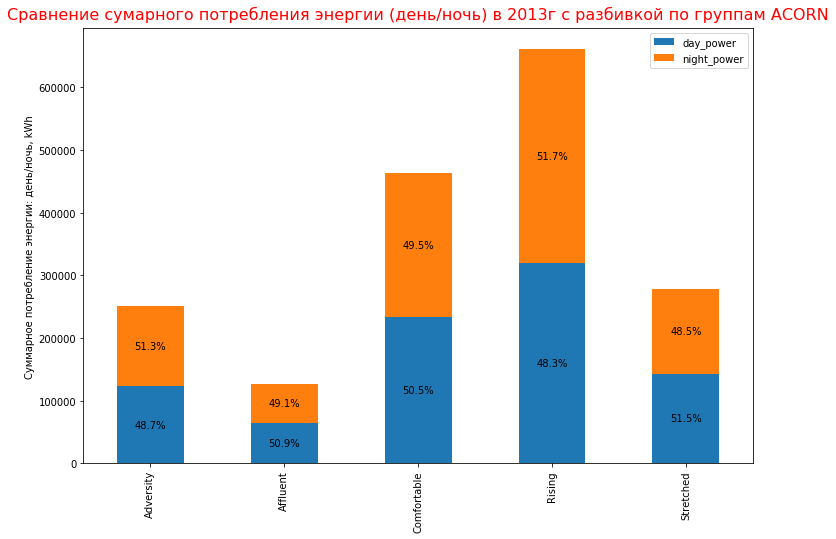

In [82]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Суммарное потребление энергии: день/ночь, kWh')
ax.set_title('Сравнение сумарного потребления энергии (день/ночь) в 2013г с разбивкой по группам ACORN', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_grouped[['day_power', 'night_power']], data_hh_block_all_grouped['summary_power'])
data_hh_block_all_grouped[['day_power', 'night_power']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

Построим круговую диаграмму, показывающую распределение долей электроэнергии каждой из групп в суммарном дневном и в суммарном ночном потреблении

In [83]:
def draw_pie (data, titles, labels=[], size = (15,15)):
    '''
    Функция draw_pie (data, titles, labels=[], size = (15,15)) отрисовывает несколько круговых диаграмм 
    по набору данных (DataFrame) data в две колонки на лист. Количество диаграмм соответствует числу столбцов в data.
    
    В качестве агругментов функция получает
        - data   - набор данных, rкаждый столбец которого необходимо отобразть на отдельной диаграмме
        - titels - заголовки диаграмм
        - labels - необязательный параметр - подписи на диаграммах (в случае, если подписи по-умолчанию требуется заменить)
        - size   - необязательный параметр задает размер холста (по умолчанию 15х15)
    '''
    #print(data)
    if len(labels)==0:
        labels = data.index.values
    for i, T in enumerate(data.columns):
        if i>=len(titles):
            titles.append(data.columns[i])
        ax = plt.subplot2grid( ((len(data.columns)-1)//2 + 1, 2), (i//2, (i+2)%2) )
        ax.set_title(titles[i], color = 'red', size = 16, verticalalignment='bottom');
        data[T].plot.pie(ax=ax, autopct='%.2f%%', subplots=False, 
                        legend = False,   figsize=size,
                        labels = labels) 
        ax.set_ylabel('')

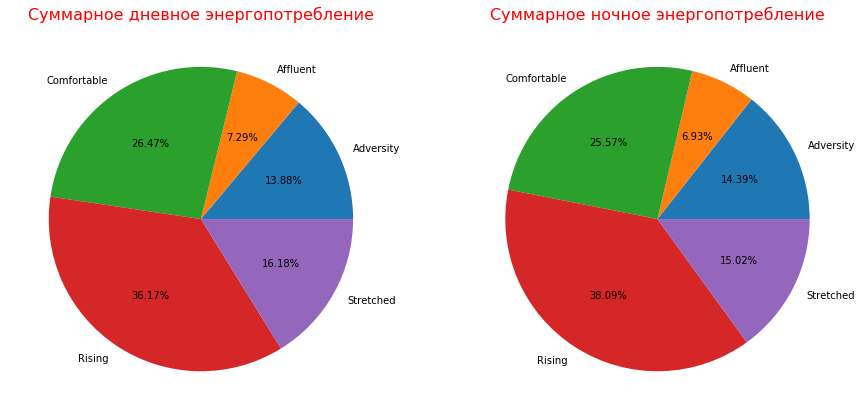

In [84]:
draw_pie(data_hh_block_all_grouped[['day_power', 'night_power']], 
         ['Суммарное дневное энергопотребление', 'Суммарное ночное энергопотребление'])
                      

Расчитаем среднее дневное и ночное потребление (на одно домохозяйство) для каждой из групп

In [85]:
data_hh_block_all_grouped['day_power_meam'] = data_hh_block_all_grouped.day_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped['night_power_meam'] = data_hh_block_all_grouped.night_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped.head()

,LCLid,day_power,night_power,summary_power,day_power_meam,night_power_meam
Acorn_grouped,,,,,,
Adversity,92,122599.416992,129091.038995,251690.455987,1332.602359,1403.163467
Affluent,30,64386.693000,62111.440002,126498.133002,2146.223100,2070.381333
Comfortable,137,233733.540008,229357.058983,463090.598991,1706.084234,1674.139117
Rising,161,319450.053990,341564.405988,661014.459978,1984.161826,2121.518050
Stretched,70,142912.104989,134688.038997,277600.143986,2041.601500,1924.114843


Построим столбиковую диаграмму среднего потребления энергии (день/ночь) в 2013г с разбивкой по группам ACORN

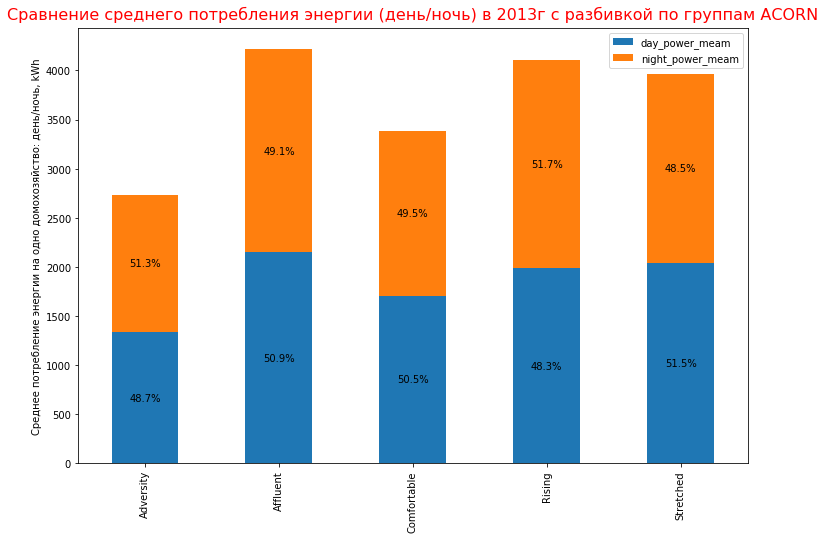

In [86]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Среднее потребление энергии на одно домохозяйство: день/ночь, kWh')
ax.set_title('Сравнение среднего потребления энергии (день/ночь) в 2013г с разбивкой по группам ACORN', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']], data_hh_block_all_grouped['summary_power']/data_hh_block_all_grouped.LCLid)
data_hh_block_all_grouped['night_power_meam'] = data_hh_block_all_grouped.night_power/data_hh_block_all_grouped.LCLid
data_hh_block_all_grouped.head()
data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

Построим круговую диаграмму, показывающую распределение долей энергопотребления в среднем на одно домовладение в каждой из групп в дневное и в ночное время

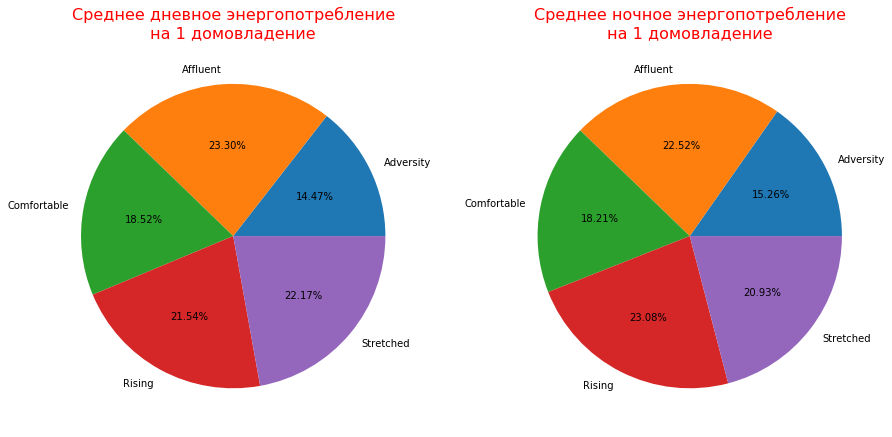

In [87]:
draw_pie(data_hh_block_all_grouped[['day_power_meam', 'night_power_meam']], 
         ['Среднее дневное энергопотребление\nна 1 домовладение', 'Среднее ночное энергопотребление\nна 1 домовладение'])


##### Представленные диаграммы наглядно показывают, что:
- *суммарное энергопотребление, в каждой из групп домовладений, определяется ее численностью. Этот факт мы уже отмечали выше*
- *доли дневного и ночного потребления электроэнергии (в светлое и темное время суток) в среднегодовом измерении практически равны друг другу во всех группах домовладений*
- *выявление факта, что доли дневного/ночного энергопотребления равны примеро 50% во всех группах домовладений, исключает возможность его дополнительного ранжирования в зависимости от принадлежности домовладения к той или иной группе. Можем лишь констатировать, уже ранее установленный результат, что в ранжировании энергопотребления в расчете на одно домовладение с большим отрывом вырывается вперед самая обеспеченная часть. Далее, с минимальным градиентом на понижение идут средний клас и менее обеспеченные.*

#### 3.3.2 Для каждой из пяти групп потребителей сравним энергопотребление (суммарно на группу и в пересчете на одно домохозяйство) с учетом выбранного тарифа в периоды: 
- T1 - пиковоая нагрузка, 
- T2 - средняя нагрузка, 
- T3 - низкая нагрузка. 

##### Сделаем выводы о периодах суток с наибольшим энергопотреблением, и о влиянии на энергопотребление выбранного тарифа в каждой из пяти групп.

Сгруппируем все домохозяйства по принадлежности к *Acorn_grouped* и выбранному тарифу *stdorToU*, и, для каждой тарифной подгруппы посчитаем суммарные значения потребления электроэнергии в периоды T1, T2, T3

In [88]:
data_hh_block_all_tariff = data_hh_block_all_sun.groupby(['Acorn_grouped','stdorToU']).agg({'LCLid': 'unique','summary_power': 'sum', 'T1_power':'sum', 'T2_power':'sum', 'T3_power':'sum'})
data_hh_block_all_tariff.head(12)

LCLid  \
Acorn_grouped stdorToU                                                      
Adversity     Std       [MAC003742, MAC003772, MAC000757, MAC002547, M...   
              ToU       [MAC002910, MAC002418, MAC001254, MAC000565, M...   
Affluent      Std       [MAC003566, MAC003863, MAC000850, MAC001528, M...   
              ToU       [MAC000593, MAC002552, MAC004713, MAC005550, M...   
Comfortable   Std       [MAC003957, MAC005002, MAC000962, MAC001021, M...   
              ToU       [MAC001718, MAC002507, MAC002909, MAC002277, M...   
Rising        Std       [MAC000715, MAC002267, MAC000317, MAC001370, M...   
              ToU       [MAC000193, MAC004714, MAC004948, MAC004318, M...   
Stretched     Std       [MAC000574, MAC002085, MAC004831, MAC004878, M...   
              ToU       [MAC000687, MAC002291, MAC002013, MAC001440, M...   

                        summary_power       T1_power       T2_power  \
Acorn_grouped stdorToU                                                
Adversity     Std       229134.398987   80018.908996   91097.611996   
              ToU        22556.057000    8016.500000    9632.616000   
Affluent      Std       104671.801003   38308.904001   42853.578001   
              ToU        21826.331999    8091.078999    8666.777999   
Comfortable   Std       397746.274992  152423.451997  163526.648999   
              ToU        65344.323999   23365.865999   26973.276000   
Rising        Std       521734.993987  184016.811994  214407.682996   
              ToU       139279.465991   50429.019997   56844.535997   
Stretched     Std       212329.722993   79314.389997   89395.854994   
              ToU        65270.420994   25173.647996   26820.564999   

                             T3_power  
Acorn_grouped stdorToU                 
Adversity     Std        58017.877994  
              ToU         4906.941000  
Affluent      Std        23509.319001  
              ToU         5068.475000  
Comfortable   Std        81796.173996  
              ToU        15005.182000  
Rising        Std       123310.498997  
              ToU        32005.909997  
Stretched     Std        43619.478001  
              ToU        13276.207999

В столбец *LCLid* полученного набора данных (*data_hh_block_all_tariff*) запишем информацию о количестве домохозяйств в каждой из подгрупп

In [89]:
data_hh_block_all_tariff['LCLid'] = data_hh_block_all_tariff.LCLid.transform(lambda x: len(x))
data_hh_block_all_tariff.head(12)

LCLid  summary_power       T1_power       T2_power  \
Acorn_grouped stdorToU                                                       
Adversity     Std          78  229134.398987   80018.908996   91097.611996   
              ToU          14   22556.057000    8016.500000    9632.616000   
Affluent      Std          23  104671.801003   38308.904001   42853.578001   
              ToU           7   21826.331999    8091.078999    8666.777999   
Comfortable   Std         114  397746.274992  152423.451997  163526.648999   
              ToU          23   65344.323999   23365.865999   26973.276000   
Rising        Std         125  521734.993987  184016.811994  214407.682996   
              ToU          36  139279.465991   50429.019997   56844.535997   
Stretched     Std          52  212329.722993   79314.389997   89395.854994   
              ToU          18   65270.420994   25173.647996   26820.564999   

                             T3_power  
Acorn_grouped stdorToU                 
Adversity     Std        58017.877994  
              ToU         4906.941000  
Affluent      Std        23509.319001  
              ToU         5068.475000  
Comfortable   Std        81796.173996  
              ToU        15005.182000  
Rising        Std       123310.498997  
              ToU        32005.909997  
Stretched     Std        43619.478001  
              ToU        13276.207999

Построим столбиковую диаграмму сумарного потребления энергии в тарифные периоды: 
- T1 (7:00-10:00, 17:00-21:00)
- T2 (10:00-17:00, 21:00-23:00)
- T3 (23:00-7:00) 

в 2013г с разбивкой по группам ACORN

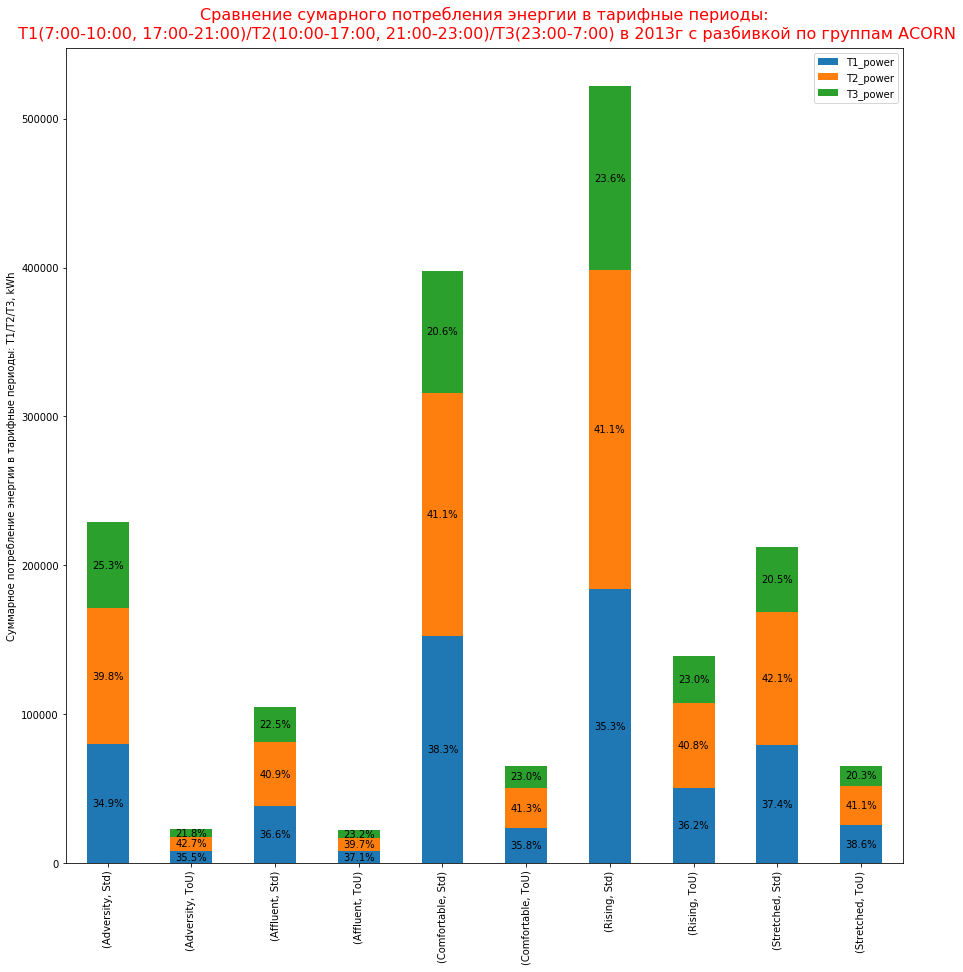

In [90]:
fig,ax=plt.subplots(figsize=(15,15))
ax.set_ylabel('Суммарное потребление энергии в тарифные периоды: T1/T2/T3, kWh')
ax.set_title('Сравнение сумарного потребления энергии в тарифные периоды:\n T1(7:00-10:00, 17:00-21:00)/T2(10:00-17:00, 21:00-23:00)/T3(23:00-7:00) в 2013г с разбивкой по группам ACORN', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_tariff[['T1_power', 'T2_power', 'T3_power']], data_hh_block_all_tariff['summary_power'])
data_hh_block_all_tariff[['T1_power', 'T2_power', 'T3_power']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

Построим круговую диаграмму, показывающую распределение долей потребленной электроэнергии по периодам с пиковой, средней, и минимальной нагрузкой отдельно для всех домовладений со стандартным тарифом и дифференициированным тарифом

In [91]:
data_hh_block_all_tariff.groupby('stdorToU').sum().T.iloc[2:5]

stdorToU,Std,ToU
T1_power,534082.466986,115076.112992
T2_power,601281.376986,128937.770995
T3_power,330253.347989,70262.715996


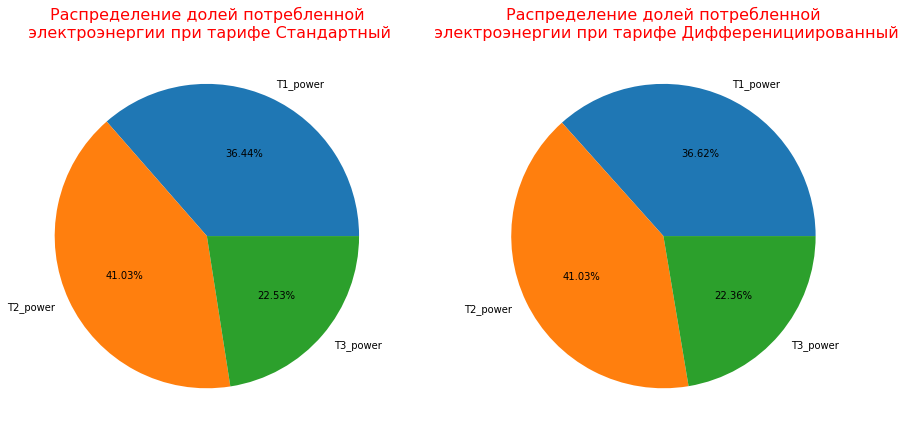

In [92]:
draw_pie(data_hh_block_all_tariff.groupby('stdorToU').sum().T[2:5], 
         ['Распределение долей потребленной\n электроэнергии при тарифе Стандартный', 'Распределение долей потребленной\n электроэнергии при тарифе Дифференициированный'])


Расчитаем среднее потребление энергии на одно домохозяйство в тарифные периоды T1/T2/T3 для каждой из групп

In [93]:
data_hh_block_all_tariff['T1_power_meam'] = data_hh_block_all_tariff.T1_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff['T2_power_meam'] = data_hh_block_all_tariff.T2_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff['T3_power_meam'] = data_hh_block_all_tariff.T3_power/data_hh_block_all_tariff.LCLid
data_hh_block_all_tariff.head()

LCLid  summary_power       T1_power       T2_power  \
Acorn_grouped stdorToU                                                       
Adversity     Std          78  229134.398987   80018.908996   91097.611996   
              ToU          14   22556.057000    8016.500000    9632.616000   
Affluent      Std          23  104671.801003   38308.904001   42853.578001   
              ToU           7   21826.331999    8091.078999    8666.777999   
Comfortable   Std         114  397746.274992  152423.451997  163526.648999   

                            T3_power  T1_power_meam  T2_power_meam  \
Acorn_grouped stdorToU                                               
Adversity     Std       58017.877994    1025.883449    1167.918103   
              ToU        4906.941000     572.607143     688.044000   
Affluent      Std       23509.319001    1665.604522    1863.199044   
              ToU        5068.475000    1155.868428    1238.111143   
Comfortable   Std       81796.173996    1337.047825    1434.444289   

                        T3_power_meam  
Acorn_grouped stdorToU                 
Adversity     Std          743.818949  
              ToU          350.495786  
Affluent      Std         1022.144304  
              ToU          724.067857  
Comfortable   Std          717.510298

Построим столбиковую диаграмму среднего потребления энергии на одно домохозяйство в тарифные периоды T1/T2/T3 в 2013г с разбивкой по группам ACORN

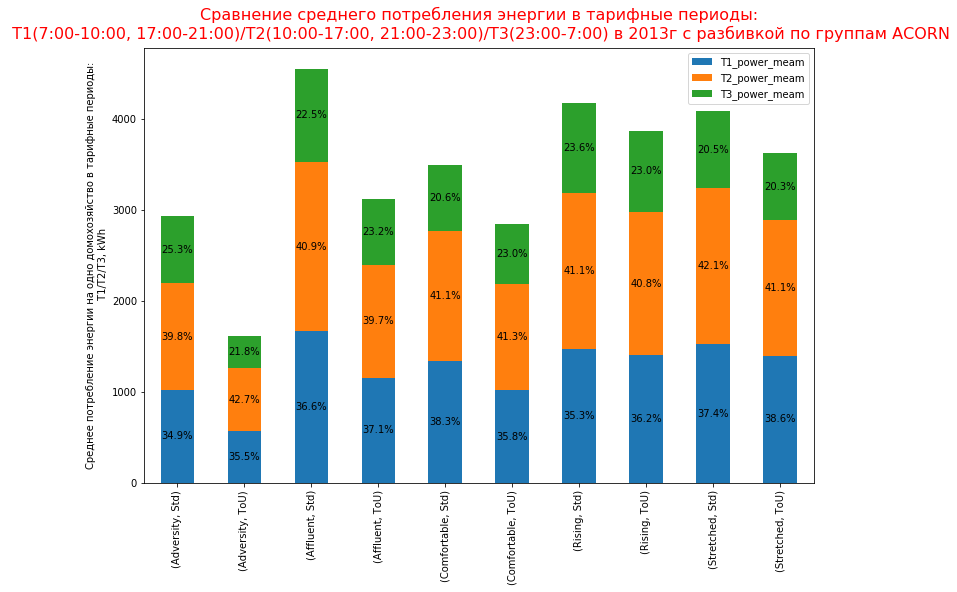

In [94]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Среднее потребление энергии на одно домохозяйство в тарифные периоды:\n T1/T2/T3, kWh')
ax.set_title('Сравнение среднего потребления энергии в тарифные периоды:\n T1(7:00-10:00, 17:00-21:00)/T2(10:00-17:00, 21:00-23:00)/T3(23:00-7:00) в 2013г с разбивкой по группам ACORN', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_hh_block_all_tariff[['T1_power_meam', 'T2_power_meam', 'T3_power_meam']], data_hh_block_all_tariff['summary_power']/data_hh_block_all_tariff.LCLid)
data_hh_block_all_tariff[['T1_power_meam', 'T2_power_meam', 'T3_power_meam']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('');

In [95]:
data_hh_block_all_tariff.T.iloc[:]

Acorn_grouped      Adversity                     Affluent                \
stdorToU                 Std           ToU            Std           ToU   
LCLid              78.000000     14.000000      23.000000      7.000000   
summary_power  229134.398987  22556.057000  104671.801003  21826.331999   
T1_power        80018.908996   8016.500000   38308.904001   8091.078999   
T2_power        91097.611996   9632.616000   42853.578001   8666.777999   
T3_power        58017.877994   4906.941000   23509.319001   5068.475000   
T1_power_meam    1025.883449    572.607143    1665.604522   1155.868428   
T2_power_meam    1167.918103    688.044000    1863.199044   1238.111143   
T3_power_meam     743.818949    350.495786    1022.144304    724.067857   

Acorn_grouped    Comfortable                       Rising                 \
stdorToU                 Std           ToU            Std            ToU   
LCLid             114.000000     23.000000     125.000000      36.000000   
summary_power  397746.274992  65344.323999  521734.993987  139279.465991   
T1_power       152423.451997  23365.865999  184016.811994   50429.019997   
T2_power       163526.648999  26973.276000  214407.682996   56844.535997   
T3_power        81796.173996  15005.182000  123310.498997   32005.909997   
T1_power_meam    1337.047825   1015.907217    1472.134496    1400.806111   
T2_power_meam    1434.444289   1172.751130    1715.261464    1579.014889   
T3_power_meam     717.510298    652.399217     986.483992     889.053055   

Acorn_grouped      Stretched                
stdorToU                 Std           ToU  
LCLid              52.000000     18.000000  
summary_power  212329.722993  65270.420994  
T1_power        79314.389997  25173.647996  
T2_power        89395.854994  26820.564999  
T3_power        43619.478001  13276.207999  
T1_power_meam    1525.276731   1398.536000  
T2_power_meam    1719.151058   1490.031389  
T3_power_meam     838.836115    737.567111

Построим круговую диаграмму, показывающую распределение долей потребленной электроэнергии в среднем на одно домовладение со стандартным тарифом и дифференициированным тарифом в каждой из групп - отдельно в периоды с пиковой, средней, и минимальной нагрузкой

In [96]:
data_hh_block_all_tariff.index.values

array([('Adversity', 'Std'), ('Adversity', 'ToU'), ('Affluent', 'Std'),
       ('Affluent', 'ToU'), ('Comfortable', 'Std'),
       ('Comfortable', 'ToU'), ('Rising', 'Std'), ('Rising', 'ToU'),
       ('Stretched', 'Std'), ('Stretched', 'ToU')], dtype=object)

In [97]:
#data_hh_block_all_tariff.index.to_flat_index()

In [98]:
print (['\n'.join(pice) for pice in data_hh_block_all_tariff.index.values])

['Adversity\nStd', 'Adversity\nToU', 'Affluent\nStd', 'Affluent\nToU', 'Comfortable\nStd', 'Comfortable\nToU', 'Rising\nStd', 'Rising\nToU', 'Stretched\nStd', 'Stretched\nToU']


In [99]:
#print (['\n'.join(pice) for pice in data_hh_block_all_tariff.index.to_flat_index()])

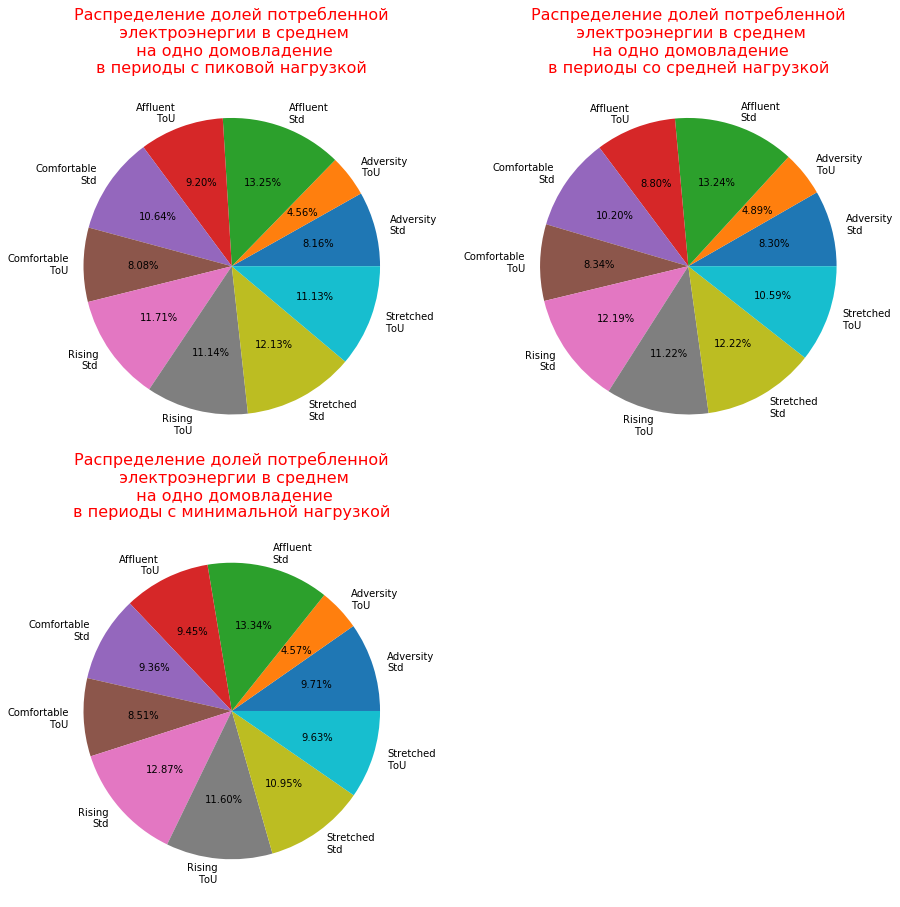

In [100]:
draw_pie(data_hh_block_all_tariff[['T1_power_meam', 'T2_power_meam', 'T3_power_meam']], 
         ['Распределение долей потребленной\n электроэнергии в среднем\n на одно домовладение\nв периоды с пиковой нагрузкой', 
          'Распределение долей потребленной\n электроэнергии в среднем\n на одно домовладение\nв периоды со средней нагрузкой',
         'Распределение долей потребленной\n электроэнергии в среднем\n на одно домовладение\nв периоды с минимальной нагрузкой'],
        ['\n'.join(pice) for pice in data_hh_block_all_tariff.index.values])




##### Выводы:
- *сравнение суммарного потребления электроэнергии всех домовладений с разбивкой по тарифным периодам показывает, что:*
    - *максимальное потребление наблюдается в период со средней нагрузкой (T2), а минимальное потребление - в период с низкой нагрузкой (T3)*
    - *при этом выбор тарифа (стандартный или дифференциируемый) не оказывает значительного влияния на потребление ни в одном из периодов T1, T2 или T3. Т.е., если не принимать во внимание принадлежность домовладений к группам (Acorn), то можно сказать, что выбор дифференциированного тарифа в среднем по всем группам не приводит к экономии электроэнергии. В противном случае мы бы наблюдали увеличение доли потребления в период T3 и уменьшения долей в T1 и T2, у домовладений с дифференциированым тарифом*
- *сравнение долей среднего потребления электроэнергии одного домовладения для каждой из групп с разбивкой по тарифным периодам показывает, что:*
    - *домовладения с дифференциированным тарифом за сутки, как правило, потребляют меньше электроэнергии, чем со стандартным тарифом. Однако эта разница достигается не за счет перераспределения потребления в пользу периода с низкой нагрузкой (и минимальным тарифом) - T3*
    - *как и случае с общим энергопотреблением, ни для  одной из групп домовладений мы не можем сказать, что выбор дифференциированного тарифа приводит к экономии электроэнергии за счет увеличения доли потребления в период T3 и уменьшения долей в T1 и T2.*

### 3.4 Для каждой из пяти групп потребителей построим графики зависимости суточного потребления энергии от длины светового дня
Совместим их на одной координатной плоскости с графиками зависимости суточного потребления энергии от среднесуточной
температуры комфорта. Найдем средний прирост потребления энергии при увеличении температуры и сокращении длины светового дня
в каждой из пяти групп в пересчете на один час.

#### 3.4.1 Построим графики зависимости суточного потребления энергии от длины светового дня, и от среднесуточной температуры

Сформируем набор данных **data_daily_graph** включающий информацию о группе потребителей и среднем дневном потреблении энергии.

In [101]:
data_daily_graph = data_daily_work_window.merge(data_informations_households, on='LCLid').groupby(['day','Acorn_grouped']).agg({'energy_sum': 'mean'}).reset_index()
data_daily_graph.head()

,day,Acorn_grouped,energy_sum
0,2013-01-01,Adversity,9.310685
1,2013-01-01,Affluent,16.395100
2,2013-01-01,Comfortable,10.677292
3,2013-01-01,Rising,13.323292
4,2013-01-01,Stretched,13.574771


In [102]:
len(data_daily_graph)

1825

In [103]:
def time_unix(row):
    '''
    Функция time_unix(row) вычисляет длину светового дня, и переводит ее в Unix формат
    '''
    return time.mktime(pd.to_datetime(row['sunsetTime']).timetuple())-time.mktime(pd.to_datetime(row['sunriseTime']).timetuple())

Создадим набор данных **data_weather_daily_graph** с информацией о длине светового дня и среднедневной температуре комфорта.

In [104]:
data_weather_daily_graph=pd.DataFrame()
data_weather_daily_graph['day']=data_weather_daily_work_window['time']
data_weather_daily_graph['time_sun_unix'] = data_weather_daily_work_window.apply(lambda  x: time_unix(x), axis = 1)
#data_weather_daily_graph['time_sun'] = data_weather_daily_graph['time_sun_unix'].apply(lambda tm :time.strftime('%H:%M', time.gmtime(tm)))
data_weather_daily_graph['apparentTemperature']=(data_weather_daily_work_window['apparentTemperatureHigh']+data_weather_daily_work_window['apparentTemperatureLow'])/2
data_weather_daily_graph.head()

,day,time_sun_unix,apparentTemperature
427,2013-09-24,43513.0,17.570
428,2013-07-26,56574.0,20.505
429,2013-07-09,58949.0,19.575
430,2013-08-08,54122.0,19.765
431,2013-01-11,29524.0,2.205


Объединим наборы данных *data_daily_graph* и *data_weather_daily_graph*.

In [105]:
data_daily_graph = data_daily_graph.merge(data_weather_daily_graph, on=['day'],how='inner')
data_daily_graph.head()

,day,Acorn_grouped,energy_sum,time_sun_unix,apparentTemperature
0,2013-01-01,Adversity,9.310685,28544.0,2.01
1,2013-01-01,Affluent,16.395100,28544.0,2.01
2,2013-01-01,Comfortable,10.677292,28544.0,2.01
3,2013-01-01,Rising,13.323292,28544.0,2.01
4,2013-01-01,Stretched,13.574771,28544.0,2.01


In [106]:
def time_label(x,pos):
    '''
    Функция time_label(x,pos) переводит время в формат Часы:Минуты из формата Unix
    '''
    return time.strftime('%H:%M', time.gmtime(x))

Построим графики зависимости среднесуточного потребления энергии от длины светового дня по группам ACCORN.

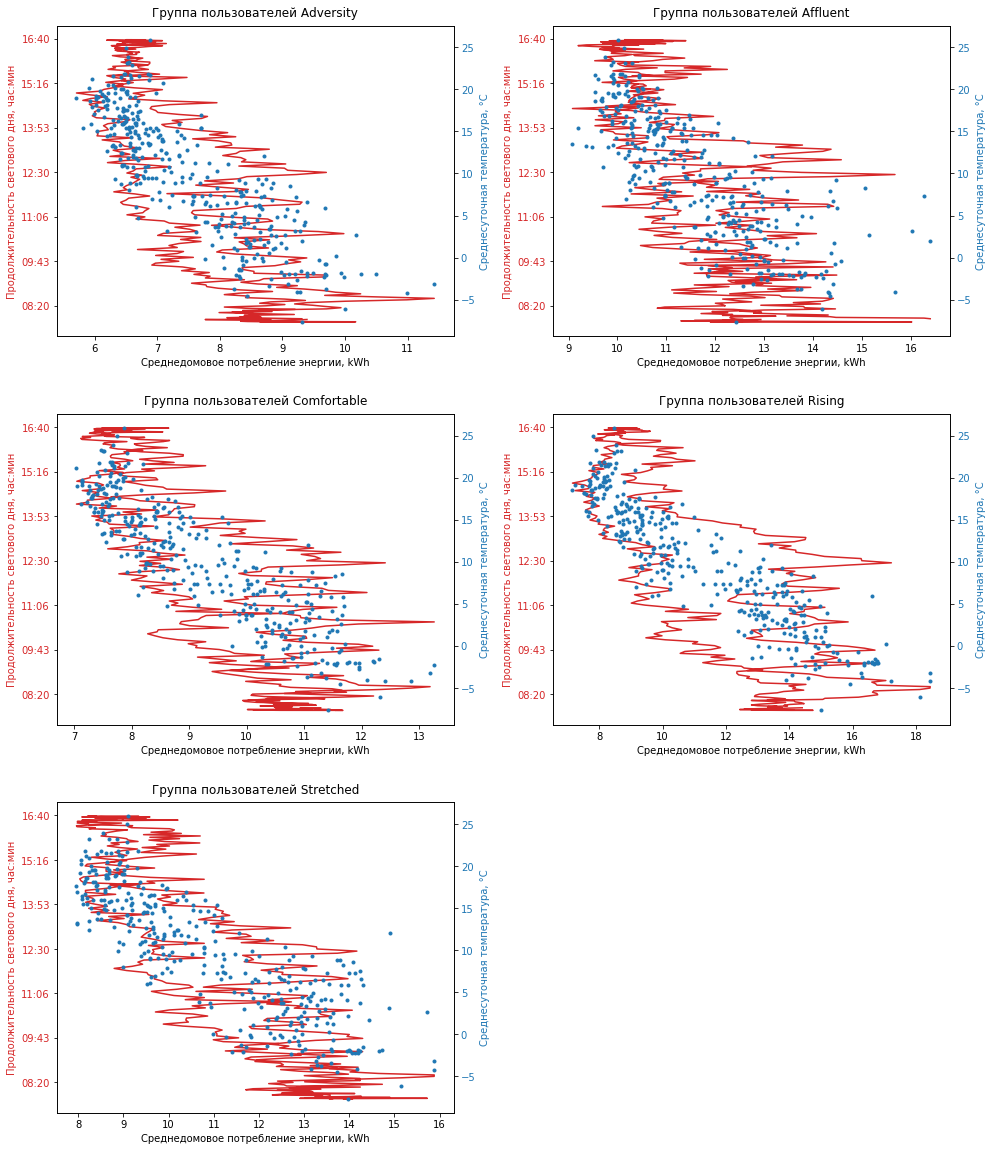

In [107]:
fig ,axs=plt.subplots(3,2,figsize=(16,20))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
axs[2,1].axis('off')
axt=axs.ravel()
z=0
for i, group in data_daily_graph.groupby('Acorn_grouped'):
    color = 'tab:red'
    color_2 = 'tab:blue'
    ax2 = axt[z].twinx()
    ax2.set_facecolor("none")
    #axt[z].scatter(group['energy_sum'],group['time_sun_unix'],color=color,marker=".")
    axt[z].plot(group['energy_sum'],group['time_sun_unix'],color=color)
    ax2.scatter(group['energy_sum'],group['apparentTemperature'],color=color_2,marker=".")
    #ax2.plot(group['energy_sum'],group['apparentTemperature'],color=color_2)
    ax2.set_ylabel('Среднесуточная температура, \N{DEGREE SIGN}С',color=color_2)
    ax2.tick_params(axis='y', labelcolor=color_2)
    ax2.set_xlabel('Пого дня')
    axt[z].set_title('Группа пользователей '+i, color = 'black', verticalalignment='bottom');
    axt[z].set_ylabel('Продолжительность светового дня, час:мин', color=color)
    axt[z].set_xlabel('Cреднедомовое потребление энергии, kWh')
    axt[z].tick_params(axis='y', labelcolor=color)
    axt[z].yaxis.set_major_formatter(mticker.FuncFormatter(time_label))
    z+=1
    

#### Из представленных графиков видно, что:
- *влияние, которое оказывает на потребление электроэнергии значение среднесуточных температур, пропорционально влиянию продолжительности светового дня* 
- *эта пропорция сохраняется для домовладений из всех пяти групп*

#### 3.4.2 Расчитаем средний прирост потребления энергии при изменении среднедневной температуры комфорта и длительности светового дня

Рассчитаем коэффициенты:
- **avg_temp**, равен количеству интервалов 5 градусов в  диапазоне среднедневной температуры комфорта.
- **avg_time**, равен количеству 1 часовых интервалов в диапазоне светового дня.

In [108]:
avg_temp=(data_daily_graph['apparentTemperature'].max()-data_daily_graph['apparentTemperature'].min())/5
avg_time=(data_daily_graph['time_sun_unix'].max()-data_daily_graph['time_sun_unix'].min())/3600

По каждой из групп потребления расчитаем средние темпы прироста потребления энергии (в %):
1. при уменьшении температуры на 5 градусов.
2. при сокращении длины светового дня на 1 час.

In [109]:
d=[]
for i, group in data_daily_graph.groupby('Acorn_grouped'):
    min_eng=group['energy_sum'].min()
    max_eng=group['energy_sum'].max()
    t_mean_time=round((math.pow((max_eng/min_eng),1/(avg_time-1))*100)-100,2)
    t_mean_temp=round((math.pow((max_eng/min_eng),1/(avg_temp-1))*100)-100,2)
    d.append((i,t_mean_time,t_mean_temp))
data_prirost=pd.DataFrame(d,columns=('Acorn_grouped','t_mean_time','t_mean_temp'))
data_prirost=data_prirost.set_index('Acorn_grouped')
data_prirost.head()

,t_mean_time,t_mean_temp
Acorn_grouped,,
Adversity,9.28,12.91
Affluent,7.85,10.90
Comfortable,8.44,11.72
Rising,12.88,18.03
Stretched,9.24,12.85


Построим диаграмму прироста потребления энергии при уменьшении светового дня на 1 час с разбивкой 
по группам ACCORN.


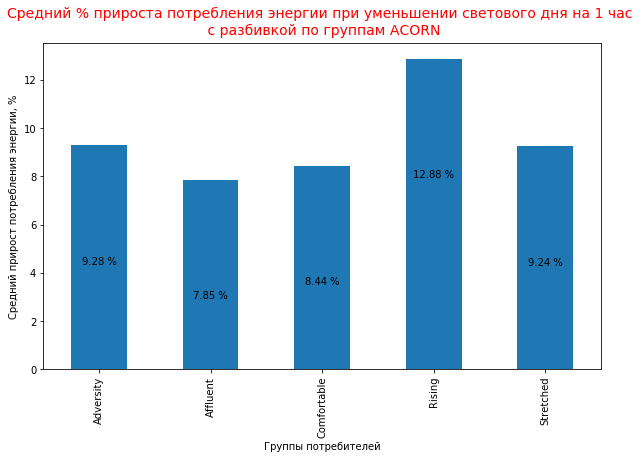

In [110]:
fig,ax=plt.subplots(figsize=(10,6))
ax.set_ylabel('Средний прирост потребления энергии, %')
ax.set_title('Средний % прироста потребления энергии при уменьшении светового дня на 1 час \n с разбивкой по группам ACORN', color = 'red', size = 14, verticalalignment='bottom');
data_prirost[['t_mean_time']].plot(ax=ax, kind='bar', stacked=True);
ax.set_xlabel('Группы потребителей')
ax.get_legend().remove()
rects = ax.patches
labels = data_prirost['t_mean_time']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height -5, str(label)+' %',ha='center', va='bottom')

Построим диаграмму прироста потребления энергии при уменьшении среднедневной температуры комфорта на 5 градусов с разбивкой по группам ACCORN.

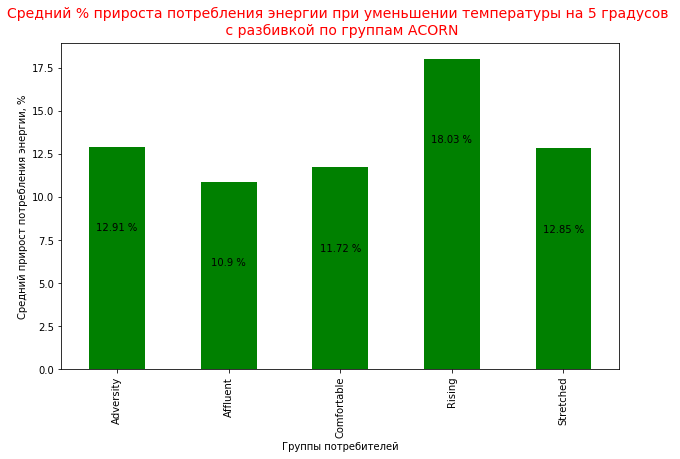

In [111]:
fig,ax=plt.subplots(figsize=(10,6))
ax.set_ylabel('Средний прирост потребления энергии, %')
ax.set_title('Средний % прироста потребления энергии при уменьшении температуры на 5 градусов \n с разбивкой по группам ACORN', color = 'red', size = 14, verticalalignment='bottom');
data_prirost[['t_mean_temp']].plot(ax=ax, kind='bar', stacked=True,color='green');
rects = ax.patches
ax.set_xlabel('Группы потребителей')
ax.get_legend().remove()
labels = data_prirost['t_mean_temp']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height -5, str(label)+' %',ha='center', va='bottom')

#### Выводы:
- *изменение значений температуры комфорта на 5 градусов (Цельсия) сопоставимо по влиянию на энергопотребление изменения длины светового дня на 1 час (примерно как 1:1.3)*
- *сильнее всего влияние обоих факторов сказывается на энергопотреблении одной из самых обеспеченных групп*

### 3.5 Исследуем зависимость суммарного потребления энергии в течении года от времени суток; от дня недели и месяца года 

Построим качественную оценку динамики энергопотребления с помощью тепловых карт: спектр потребления энергии от темно-синего (мин.) до темно-красного (макс)

#### a) Тепловая карта потребления электроэнергии - время года/время суток:  по осям дни года (ось Y) и часы суток (ось X).

При формировании набора данных для тепловой карты будем использовать выборку *data_hh_block_all*. 

Сгруппируем этот набор данных по ключу **'day'** и найдем средние значения от потребления электроэнергии всеми домовладениями в течении каждых суток года. Запишем полученный набор данных в переменную **data_heatmap_all**, которую и будем использовать при построении графика тепловой карты.

In [112]:
data_heatmap_all = data_hh_block_all.groupby('day').mean()
data_heatmap_all.index = data_heatmap_all.index.date
data_heatmap_all.head()

,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,05:00:00,...,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00,00:00:00
2013-01-01,0.250394,0.237016,0.217316,0.200453,0.175320,0.165408,0.152012,0.142994,0.141976,0.136227,...,0.380573,0.381967,0.377245,0.365118,0.353900,0.341096,0.317378,0.297553,0.268851,0.239353
2013-01-02,0.231564,0.204838,0.185577,0.168650,0.143577,0.127370,0.127088,0.127292,0.129286,0.131143,...,0.417446,0.418910,0.399337,0.378947,0.356104,0.342732,0.319472,0.293836,0.261196,0.235898
2013-01-03,0.234186,0.199965,0.168371,0.153835,0.133082,0.126208,0.123612,0.120559,0.121549,0.119353,...,0.405488,0.396057,0.389282,0.368394,0.358773,0.329447,0.302588,0.283778,0.272433,0.240531
2013-01-04,0.218669,0.190877,0.164624,0.143350,0.133012,0.124434,0.124012,0.115761,0.117006,0.110628,...,0.378855,0.381264,0.370963,0.350092,0.343732,0.325734,0.308033,0.289603,0.264904,0.239176
2013-01-05,0.229112,0.205478,0.176322,0.163606,0.146549,0.134845,0.120214,0.121218,0.122496,0.119914,...,0.393341,0.387163,0.348110,0.335259,0.323939,0.308322,0.287816,0.277506,0.264816,0.241394


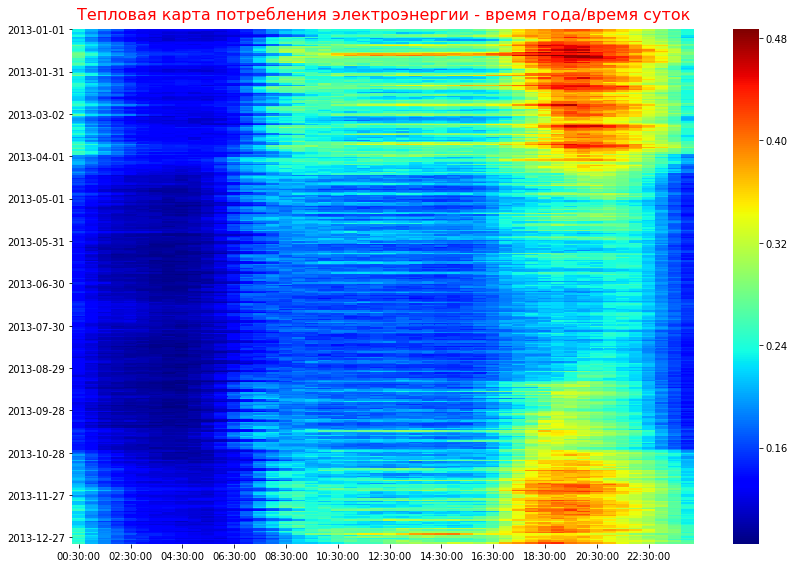

In [113]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_title('Тепловая карта потребления электроэнергии - время года/время суток', color = 'red', size = 16, 
             verticalalignment='bottom');
sns.heatmap(data_heatmap_all, cmap = 'jet', xticklabels = 4, yticklabels = 30)
fig.tight_layout()
plt.show()


##### Данная тепловая карта иллюстрирует хотя и вполне ожидаемый, но весьма наглядный результат:
- *самое большое потребление электроэнергии в течении года происходит в вечерние часы с 17:00 24:00*
- *на втором месте по потреблению дневные часы с 9:00 до 17:00*
- *пиковые значения приходятся на часы с 18:30 до 22:00 в период с конца октября по начало апреля*

#### б) Тепловая карта потребления электроэнергии - дни недели/недели года: по осям неделя года (ось Y) и дни недели (ось X).

При формировании набора данных для тепловой карты будем использовать выборку *data_daily_work_window*

In [114]:
data_daily_work_window.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3653,MAC000234,2013-01-01,0.1240,0.149500,0.390,48,0.101889,7.176,0.033
3654,MAC000234,2013-01-02,0.1890,0.229417,0.524,48,0.119337,11.012,0.044
3655,MAC000234,2013-01-03,0.1815,0.341854,1.923,48,0.419854,16.409,0.033
3656,MAC000234,2013-01-04,0.3115,0.422458,1.440,48,0.359611,20.278,0.068
3657,MAC000234,2013-01-05,0.1980,0.244062,0.590,48,0.153197,11.715,0.033


Из этой выборки нам нужны столбцы *'LCLid', 'day', 'energy_sum'*, а также необходимо добавить столбцы день-недели и номер-недели-года -> **data_week**

In [115]:
data_week = data_daily_work_window.loc[:,['LCLid', 'day', 'energy_sum']]
data_week['weekday'] = data_week['day'].dt.weekday
data_week['weekofyear'] = data_week['day'].dt.weekofyear
data_week.head()

,LCLid,day,energy_sum,weekday,weekofyear
3653,MAC000234,2013-01-01,7.176,1,1
3654,MAC000234,2013-01-02,11.012,2,1
3655,MAC000234,2013-01-03,16.409,3,1
3656,MAC000234,2013-01-04,20.278,4,1
3657,MAC000234,2013-01-05,11.715,5,1


Для каждой строки в наборе *data_week* определим день недели и запишем потребленную в этот день электроэнергию в соотвествующий столбец

In [116]:
week = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
[week[day]  for day in week]

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [117]:
def get_week(row):
    return pd.Series([row['energy_sum'] if (day == row['weekday']) else np.NaN for day in week])

data_week[[week[day] for day in week]] = data_week.apply(get_week, axis=1)
data_week.head()

,LCLid,day,energy_sum,weekday,weekofyear,Mon,Tue,Wed,Thu,Fri,Sat,Sun
3653,MAC000234,2013-01-01,7.176,1,1,NaN,7.176,NaN,NaN,NaN,NaN,NaN
3654,MAC000234,2013-01-02,11.012,2,1,NaN,NaN,11.012,NaN,NaN,NaN,NaN
3655,MAC000234,2013-01-03,16.409,3,1,NaN,NaN,NaN,16.409,NaN,NaN,NaN
3656,MAC000234,2013-01-04,20.278,4,1,NaN,NaN,NaN,NaN,20.278,NaN,NaN
3657,MAC000234,2013-01-05,11.715,5,1,NaN,NaN,NaN,NaN,NaN,11.715,NaN


Удалим не нужные нам столбцы *'day', 'energy_sum', 'weekday'*. Сгруппируем по составному ключу (**'weekofyear', 'LCLid'**) и просуммируем значения столбцов: *'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'*. Получим в каждой строке значения потребления электроэнергии одного домовладения в течении одной недели. Затем сгруппируем полученный набор по ключу **'weekofyear'** и найдем средние значения от потребления электроэнергии всеми домовладениями в течении каждой недели года. Запишем этот набор данных в переменной **data_heatmap_week**, которую и будем использовать при построении графика тепловой карты.

In [118]:
#data_week.drop(columns = ['day', 'energy_sum', 'weekday'], inplace=True)
#data_week.head()
data_heatmap_week = data_week.drop(columns = ['day', 'energy_sum', 'weekday']).groupby(['weekofyear', 'LCLid']).sum().groupby('weekofyear').mean()
data_heatmap_week.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
weekofyear,,,,,,,
1,11.982233,24.513933,11.980288,11.561229,11.393037,11.656880,11.818490
2,11.600953,11.239947,10.949267,11.919071,12.084986,13.217943,13.622555
3,13.028602,12.898937,13.296590,13.281941,14.000957,14.826037,15.010269
4,13.735755,13.318284,13.428547,13.421853,13.161478,12.480951,12.681543
5,12.102484,11.076876,10.847588,11.165596,11.731033,12.588284,13.244300


In [119]:
#data_heatmap_week = data_week.groupby(['weekofyear', 'LCLid']).sum().groupby('weekofyear').mean()
#data_heatmap_week.head()

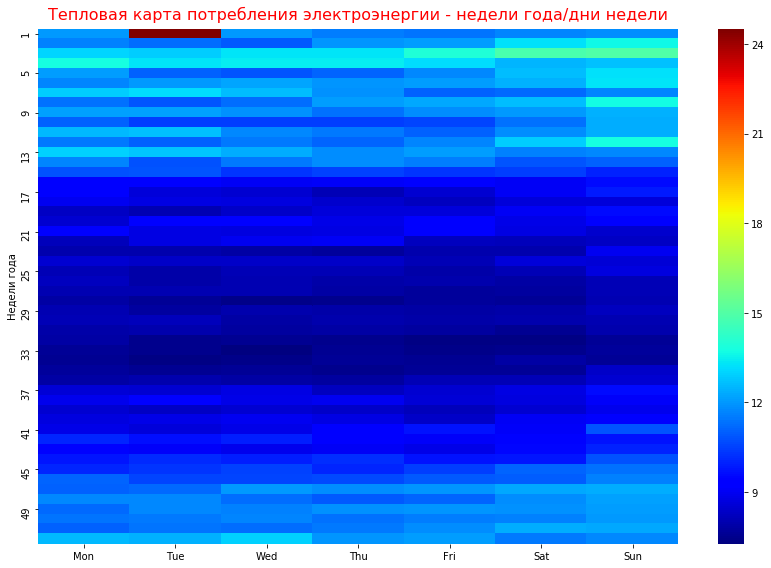

In [120]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_title('Тепловая карта потребления электроэнергии - недели года/дни недели', color = 'red', size = 16, 
             verticalalignment='bottom');
sns.heatmap(data_heatmap_week, cmap = 'jet', yticklabels = 4, xticklabels = 1)
ax.set_ylabel('Недели года')
fig.tight_layout()
plt.show()

##### Любопытный факт:
- *какой-то явной закономерности в зависимости энергопотребления от дня недели в течении года обнаружить не удалось*
- *выделяется на фоне других по значению энергопотребления единственный день в году - вторник первой недели года. Это 1 января 2013*
- *в период с октября по апрель энергопотребление выше в течении всей недели, незначительно увеличиваясь в выходные дни*

### 3.6 Подробнее исследуем зависимость потребления энергии от среднесуточных температур в течении года

#### 3.6.1 Построим математическую модель зависимости энергопотребления от температуры наружного воздуха

покажем разброс среднего суточного потребления энергии всех домохозяйств для каждого значения среднесуточной температуры во всем диапазоне температур за год. И покажем общий градиент.


In [121]:
data_weather_hourly_work_window.columns

Index(['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary', 'day'],
      dtype='object')

Посчитаем среднесуточную температуру для каждых суток в выборке *data_weather_hourly_work_window* -> **data_temp_mean**

In [122]:
data_daily_temp_mean = data_weather_hourly_work_window.groupby('day').agg({'apparentTemperature': 'mean', 'temperature': 'mean'})
data_daily_temp_mean.head(15)

,apparentTemperature,temperature
day,,
2013-01-01,2.160417,5.222500
2013-01-02,4.462083,6.717917
2013-01-03,10.277391,10.574348
2013-01-04,7.889583,9.641667
2013-01-05,8.045417,9.112500
2013-01-06,6.140417,7.596667
2013-01-07,6.021667,8.061667
2013-01-08,8.760417,9.864167
2013-01-09,6.333750,7.196250


Получим оценку максимального, минимального и медианного суточного потребления электроэнергии по всем домовладениям в выборке (*data_daily_work_window*)

In [123]:
data_daily_work_window['energy_sum'].max()

124.24700009999997

In [124]:
data_daily_work_window['energy_sum'].min()

0.0

In [125]:
data_daily_work_window['energy_sum'].median()

7.6549999999999985

*Таким образом, мы видим, что разрыв между максимумом и медианой колоссальный! Для дальнейшего анализа этой выборки мы должны усреднить все значения потребленной энергии всех домовладений за каждые сутки.*

Найдем значения среднего суточного потребления энергии всех домохозяйств в течении 2013 года -> **data_energ_mean**

In [126]:
data_daily_energy_mean = data_daily_work_window[['day', 'energy_sum']].groupby('day').mean()
data_daily_energy_mean.head()

,energy_sum
day,
2013-01-01,12.054100
2013-01-02,12.004787
2013-01-03,11.561229
2013-01-04,11.416335
2013-01-05,11.656880


Добавим в набор *data_daily_energy_mean* данные о среднесуточной температуре -> **data_daily_energy_temp_mean**

In [127]:
data_daily_energy_temp_mean = data_daily_energy_mean.merge(data_daily_temp_mean, on='day')
data_daily_energy_temp_mean.head()

,energy_sum,apparentTemperature,temperature
day,,,
2013-01-01,12.054100,2.160417,5.222500
2013-01-02,12.004787,4.462083,6.717917
2013-01-03,11.561229,10.277391,10.574348
2013-01-04,11.416335,7.889583,9.641667
2013-01-05,11.656880,8.045417,9.112500


In [128]:
len(data_daily_energy_temp_mean)

365

На графике покажем разброс среднего суточного потребления энергии всех домохозяйств для каждого значения среднесуточной температуры во всем диапазоне температур за год. И покажем общий градиент.

In [129]:
x = data_daily_energy_temp_mean['temperature'].values
y = data_daily_energy_temp_mean['energy_sum'].values
[min(x), max(x), min(y), max(y)]

[-1.3637499999999996, 25.37347826086956, 7.307429157700208, 15.040965237423295]

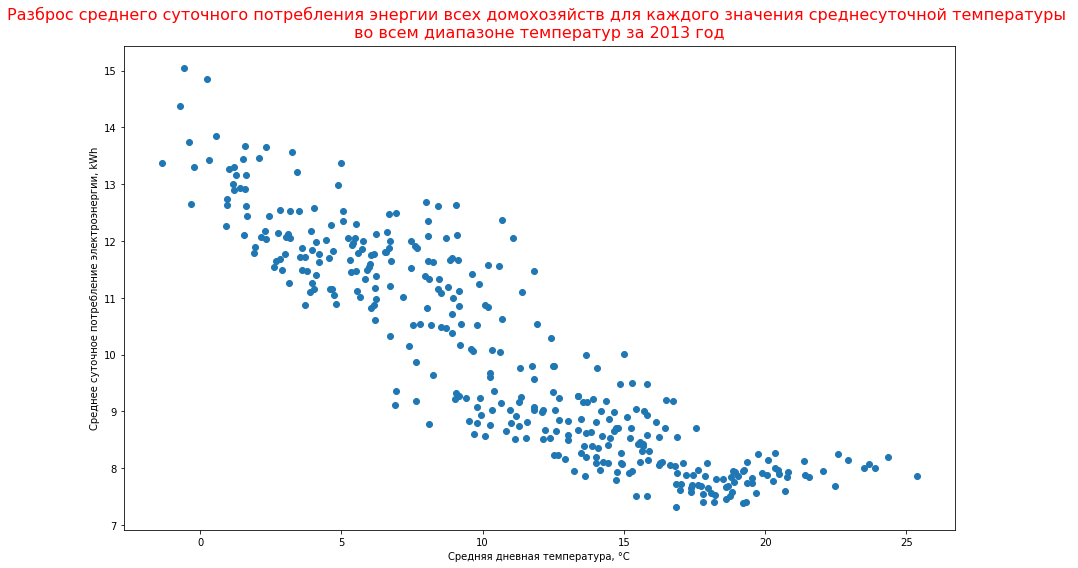

In [130]:
fig,ax=plt.subplots(figsize=(15,8))
ax.set_title('Разброс среднего суточного потребления энергии всех домохозяйств для каждого значения среднесуточной температуры \nво всем диапазоне температур за 2013 год', color = 'red', size = 16, 
             verticalalignment='bottom');

ax.scatter(x, y, marker = 'o')
ax.set_xlabel('Средняя дневная температура, \N{DEGREE SIGN}С')
ax.set_ylabel('Среднее суточное потребление электроэнергии, kWh')
fig.tight_layout()
plt.show()

Покажем общий градиент функции зависимости энергопотребления от температуры наружного воздуха. Из предыдущего графика видно, что *эта функция имеет почти линейный убывающий характер в зоне низких температур и практически не изменяется при температурах выше +16. Отсюда следует, что градиент можно построить с помощью **функции кусочно-линейной регрессии**, использующей **метод наименьших квадратов** (**МНК** - curve_fit)*

[17.10940334 13.33407021 -0.32138807]


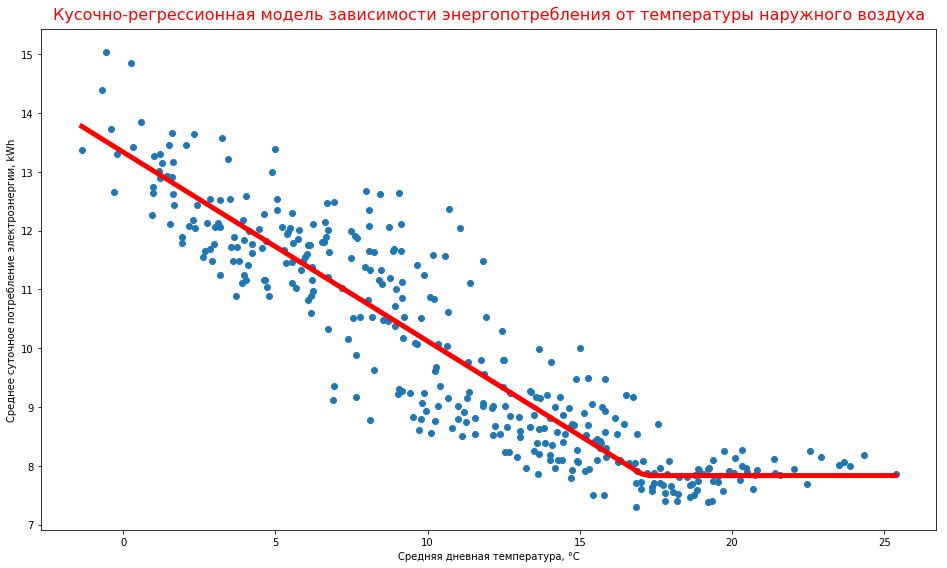

In [131]:
def piecewise_linear(x, x0, y0, k):
    '''
    модельная функция f(x, *args) задающая функцию линейной регрессии
    '''
    return np.piecewise(x, [x < x0, x>=x0], [lambda x: k*x + y0, lambda x: k*x0 + y0 ])

fig,ax=plt.subplots(figsize=(14,8))
ax.set_title('Кусочно-регрессионная модель зависимости энергопотребления от температуры наружного воздуха', color = 'red', size = 16, 
             verticalalignment='bottom');

ax.scatter(x, y, marker = 'o')
xd = np.linspace(min(x), max(x), 100)

bounds = [[-2, 0, -3], [30, 100, 4]]
p , e = optimize.curve_fit(piecewise_linear, x, y, bounds = bounds)
print (p)
plt.plot(xd, piecewise_linear(xd, *p),color='r',linewidth=5.0);
ax.set_xlabel('Средняя дневная температура, \N{DEGREE SIGN}С')
ax.set_ylabel('Среднее суточное потребление электроэнергии, kWh')
fig.tight_layout()
plt.show()

#### У нас получилась регрессионая модель зависимости потребления энергии от наружной температуры в зимний период и прямая в летний период. 
Эта модель, называемая **PTG** (*Power Temperature Gradient*), часто используется при анализе энергоэффективности систем. Более подробное описание модели можно найти по ссылкам: http://discovery.ucl.ac.uk/1473400/1/1-s2.0-S0378778815302905-main.pdf или http://www.ibpsa.org/proceedings/BS2015/p2854.pdf

#### 3.6.2 Найдем оценку R-квадрат (коэффициент детерминации; в Python - r2_score) 

Она позволяет оценить меру зависимости одной случайной величины от множества других (в нашем случае потребленной энергии от температуры). Чем ближе значение R-квадрат к 1, тем эта зависимость более явная. Из результатов, полученных в предудущем п.**3.6.1** можно сделать вывод, что **если значение R-квадрат больше 70%, то часть домовладений использует электроэнергию для отопления в зимний период**

Коэффициент детерминации расчитывается по формуле: 

#### r2_score = r**2 
где r - коэффициент корреляции. 

Найдем корелляцию между величинами потребленной энергии и значениями температуры

Для нахождения коэффициента корреляции добавим следующие данные (здесь и далее под температурой 
                                                                 понимается температура комфорта):
   - столбец **'xy'** - произведение средней температуры за день на суммарное потребление энергии за этот день
   - столбец **'xx'** - квадрат дневной энергии
   - столбец **'yy'** - квадрат средней температуры
    

In [132]:
data_daily_energy_temp_mean['xy']=data_daily_energy_temp_mean.apply(lambda xy: xy['energy_sum']*xy['apparentTemperature'],axis =1)
data_daily_energy_temp_mean['xx']=data_daily_energy_temp_mean.apply(lambda xx: xx['energy_sum']**2,axis =1)
data_daily_energy_temp_mean['yy']=data_daily_energy_temp_mean.apply(lambda yy: yy['apparentTemperature']**2,axis =1)
data_daily_energy_temp_mean.head(20)

,energy_sum,apparentTemperature,temperature,xy,xx,yy
day,,,,,,
2013-01-01,12.054100,2.160417,5.222500,26.041879,145.301327,4.667400
2013-01-02,12.004787,4.462083,6.717917,53.566361,144.114919,19.910188
2013-01-03,11.561229,10.277391,10.574348,118.819270,133.662006,105.624772
2013-01-04,11.416335,7.889583,9.641667,90.070129,130.332713,62.245525
2013-01-05,11.656880,8.045417,9.112500,93.784453,135.882842,64.728729
2013-01-06,11.915761,6.140417,7.596667,73.167739,141.985368,37.704717
2013-01-07,11.648498,6.021667,8.061667,70.143372,135.687504,36.260469
2013-01-08,11.239947,8.760417,9.864167,98.466618,126.336407,76.744900
2013-01-09,11.016717,6.333750,7.196250,69.777129,121.368045,40.116389


Для нахождения коэффициента корреляции нам понадобится:
- **count** - длина выборки
- **sum_x** - суммарное количество потребленной энергии в данной выборке
- **sum_y** - сумма температур по всей выборке
- **sum_xy**, **sum_xx**, **sum_yy** - вспомогательные данные (для *метода наименьших квадратов*). 

In [133]:
count = len(data_daily_energy_temp_mean)
sum_x = data_daily_energy_temp_mean['energy_sum'].sum()
sum_y = data_daily_energy_temp_mean['apparentTemperature'].sum()
sum_xy = data_daily_energy_temp_mean['xy'].sum()
sum_xx = data_daily_energy_temp_mean['xx'].sum()
sum_yy = data_daily_energy_temp_mean['yy'].sum()
print('count = {:.2f}, sum_x = {:.2f}, sum_y = {:.2f}, sum_xy = {:.2f}, sum_xx = {:.2f}, sum_yy = {:.2f}'.format(count,sum_x,sum_y,sum_xy,sum_xx,sum_yy))

count = 365.00, sum_x = 3651.26, sum_y = 3493.92, sum_xy = 30435.23, sum_xx = 37798.81, sum_yy = 52801.38


Вычислим среднюю температуру по выборке *(y)*, среднедневное потребление энергии *(x)* и среднее
произведение температуры на энергию *(xy)*. 
**sigma_x** и **sigma_y** - среднеквадратические отклонения компонент.

In [134]:
x = sum_x/count 
y = sum_y/count
xy = sum_xy/count
sigma_x = ((sum_xx)/count-x**2)**0.5
sigma_y = ((sum_yy)/count-y**2)**0.5
print('x = {:.2f}, y = {:.2f}, sigma_x = {:.2f}, sigma_y = {:.2f}'.format(x,y,sigma_x,sigma_y))

x = 10.00, y = 9.57, sigma_x = 1.87, sigma_y = 7.28


Подставляя найденные числовые значения средних значений и среднеквадратических отклонений, получаем искомый коэффициент корреляции:

In [135]:
r = (xy-x*y)/(sigma_x*sigma_y)
r

-0.9095304343765188

Сделаем проверку полученного результата с помощью native методов Pandas 

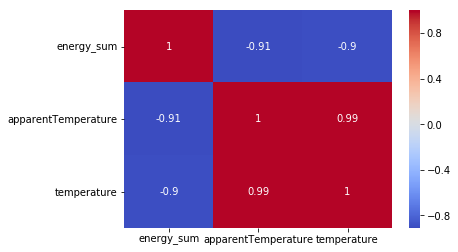

In [136]:
correlation = data_daily_energy_temp_mean[['energy_sum', 'apparentTemperature', 'temperature']].corr()
sns.heatmap(correlation, annot = True, cmap = 'coolwarm');

#### Найдя значение корреляции можем расчитать коэффициент детерминации:

In [137]:
r2_score = r**2
r2_score

0.827245611057139

#### Вывод: 
*полученное значение R-квадрат показывает выскокую зависимость величин потребленой электроэнергии и значений измеренной температуры наружного воздуха в течении календарного года.*
##### Следовательно наше предположение, что часть домовладений использует электроэнергию для отопления в зимний период, справедливо.


#### 3.6.3 Найдем долю домовладений, предположительно использующих электроэнергию для отопления 

Для этого найдем отношение среднего потребления зимой и летом для каждого домохозяйства. Будем считать, если зимнее потребление больше летнего в 1.3 раза и выше, то дом отапливается электроэнергией. Посчитаем долю таких домов в каждой из пяти групп потребителей

Для оценки зимнего и летнего режимов энергопотребления будем использовать интервал в течении суток, в который любое энергопотребление, связанное с социальной и бытовой активностью сведено к минимуму - это ночное время суток (соответствует *тарифному интервалу с минимальной нагрузкой на сеть* - **T3**). *Таким образом, энергопотребление в этом интервале суток должно быть примерно одинаковым в течении всего года, за исключением случаев использования электроэнергии для отопления дома.* 

Для вычислений будем использовать набор данных *data_hh_block_all_sun*, уже содержащий информацию о ежесуточном потреблении энергии в тарифные интервалы T1, T2, T3

In [138]:
data_hh_block_all_sun.head()

,LCLid,day,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,...,sunriseTime,sunsetTime,day_power,night_power,summary_power,T1_power,T2_power,T3_power,Acorn_grouped,stdorToU
0,MAC003566,2013-01-01,0.605,0.556,0.646,0.549,0.593,0.558,0.556,0.524,...,2013-01-01 08:07:21,2013-01-01 16:03:05,15.683,25.856,41.539,13.769,18.769,9.001,Affluent,Std
1,MAC003566,2013-01-02,0.535,0.595,0.521,0.511,0.585,0.589,0.567,0.565,...,2013-01-02 08:07:12,2013-01-02 16:04:09,10.422,26.349,36.771,14.027,12.843,9.901,Affluent,Std
2,MAC003566,2013-01-03,1.070,0.559,0.528,0.611,0.533,0.560,0.567,0.539,...,2013-01-03 08:07:00,2013-01-03 16:05:15,17.146,26.787,43.933,14.052,20.049,9.832,Affluent,Std
3,MAC003566,2013-01-04,0.614,0.562,0.614,0.612,0.630,0.618,0.616,0.557,...,2013-01-04 08:06:45,2013-01-04 16:06:24,13.657,25.288,38.945,12.318,17.004,9.623,Affluent,Std
4,MAC003566,2013-01-05,0.634,0.604,0.679,0.601,0.657,0.621,0.646,0.625,...,2013-01-05 08:06:26,2013-01-05 16:07:35,14.494,18.887,33.381,9.388,13.996,9.997,Affluent,Std


In [139]:
begin_winter = datetime.datetime(2013, 12, 1)
end_winter = datetime.datetime(2013, 3, 1)
end_spring = datetime.datetime(2013, 6, 1)
end_summer = datetime.datetime(2013, 9, 1)

data_season = {
    'summer': pd.DataFrame(data_hh_block_all_sun.loc[(data_hh_block_all_sun['day']>=end_spring)&(data_hh_block_all_sun['day']<end_summer)]),
    'winter': pd.DataFrame(data_hh_block_all_sun.loc[((data_hh_block_all_sun['day']<end_winter)|(data_hh_block_all_sun['day']>=begin_winter))])
}

In [140]:
#data_season['winter'].head()

In [141]:
#data_season['summer'].head()

Найдем отношение среднего потребления всех домовладений в зимний период к летнему периоду

In [142]:
pice_energy = dict()
for season in data_season:
    pice_energy[season] = data_season[season].groupby('day').agg({'T3_power': 'sum'})['T3_power'].mean()
    
print('Суточное среднее потребление всех домовладений:\n'+
      'Зима - {:.2f}KWh, Лето - {:.2f}KWh \nОтношение потребления Зима/Лето - {:.2f}'.format(
          pice_energy['winter'], pice_energy['summer'], pice_energy['winter']/pice_energy['summer'])
     )


Суточное среднее потребление всех домовладений:
Зима - 1308.74KWh, Лето - 919.45KWh 
Отношение потребления Зима/Лето - 1.42


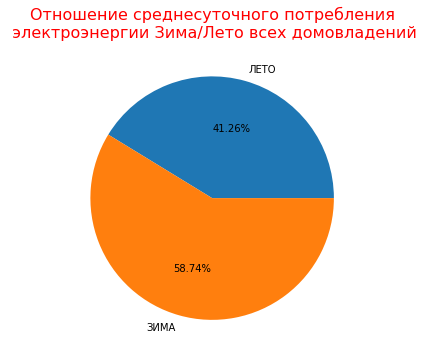

In [143]:
draw_pie(pd.DataFrame({'Season': pice_energy}), 
         ['Отношение среднесуточного потребления\n электроэнергии Зима/Лето всех домовладений'], 
         ['ЛЕТО', 'ЗИМА'], size = (12,12))

Теперь посчитаем отношение среднего потребления Зима/Лето в каждой из групп домовладений (Acorn_grouped) и определим, какие из домовладений используют электроэнергию для отопления

In [144]:
def get_electric_heating(data_winter, data_summer, ratio = 1.3):
    '''    
    функция get_electric_heating(data_winter, data_summer, ratio)
    возвращает список домов, которые потребляют в среднем в зимний период энергии больше,
    чем в ratio раз
    в качестве аргументов полачает 
        data_winter - таблица, каждая строка которой состоит из номера домовладения (LCLid) и 
                      средней потребляемой на интервале c низким расходом в зимний сезон электроэнергии
        data_summer - таблица, каждая строка которой состоит из номера домовладения (LCLid) и 
                      средней потребляемой на интервале c низким расходом в летний сезон электроэнергии                  
        ratio - необязательный параметр, коэффициент на отопление
    '''
    data_electric_heating = data_winter.groupby('LCLid').agg({'low_power': 'mean'}).rename(columns = {'low_power': 'winter'})
    data_electric_heating = data_electric_heating.merge(
        data_summer.groupby('LCLid').agg({'low_power': 'mean'}).rename(columns = {'low_power': 'summer'}),
        on ='LCLid')
    data_electric_heating['div'] = data_electric_heating['winter']/data_electric_heating['summer']    
    return data_electric_heating.query('div >={}'.format(ratio)).index
    
    

In [145]:
def factor_acorn_group(data, group, season, low_consumption = 'T3_power'):
    '''    
    функция factor_acorn_group(data, group, season)
    для заданного сезона (season) и группы (group) домовладений возвращает набор из:
        - таблицы, каждая строка которой состоит из номера домовладения (LCLid) и 
          значения средней потребляемой за сутки в заданный сезон электроэнергии
        - среднего за период low_consumption потребления электроэнергии всей группы в данный сезон
    в качестве аргументов полачает: 
        data   - данные с суточным потреблением электроэнергии всех домовладений в зависимости от сезона. Данные за сезон
                 доступны по ключу ('winter'/'summer')
        group  - наименвание группы домовладений
        season - наименование сезона ('winter'/'summer')
        low_consumption - период времени в сутках с низким потреблением электроэнергии (по умолчанию T3)
    '''
    
    group_energy = data_season[season][data_season[season]['Acorn_grouped']==group].rename(columns = {low_consumption: 'low_power'})
    return group_energy, group_energy.groupby('day').agg({'low_power': 'sum'})['low_power'].mean()
    

In [146]:
groups = data_hh_block_all_sun['Acorn_grouped'].unique()
groups

array(['Affluent', 'Rising', 'Comfortable', 'Stretched', 'Adversity'],
      dtype=object)

Создадим структуру **electric_heating_list**, где каждая запись соответсвует группе из *Acorn_grouped* и является словарем вида:

- **'houses'**: число домовладений, отапливаемых в зимний сезон
- **'winter_mean'**: среднее за период T3 потребление электроэнергии всей группы в зимний сезон
- **'summer_mean'**: среднее за период T3 потребление электроэнергии всей группы в летний сезон
- **'total_houses'**: общее количество домовладений в группе


In [147]:
electric_heating_list ={}
for group in groups:
    winter, winter_mean = factor_acorn_group(data_season, group, 'winter')
    summer, summer_mean = factor_acorn_group(data_season, group, 'summer')    
    electric_heating_list[group] = {'houses': len(get_electric_heating(winter, summer, 1.20)), 
                                    'winter_mean': winter_mean,
                                    'summer_mean': summer_mean,
                                    'total_houses': len(winter['LCLid'].unique())
                                   }

Для последующей обработки преобразуем структуру *electric_heating_list* в DataFrame и транспонируем его -> **data_electric_heating**

In [148]:
data_electric_heating = pd.DataFrame(electric_heating_list).T
#data_electric_heating

In [149]:
data_electric_heating['ratio_energy'] = data_electric_heating['winter_mean']/data_electric_heating['summer_mean']
data_electric_heating['ratio_houses'] = data_electric_heating['houses']/data_electric_heating['total_houses']
data_electric_heating['less_heating'] = data_electric_heating['total_houses']  - data_electric_heating['houses']
data_electric_heating

,houses,summer_mean,total_houses,winter_mean,ratio_energy,ratio_houses,less_heating
Affluent,10.0,75.270033,30.0,83.913244,1.114829,0.333333,20.0
Rising,92.0,324.771783,161.0,536.667789,1.652446,0.571429,69.0
Comfortable,49.0,242.128707,137.0,294.505200,1.216317,0.357664,88.0
Stretched,27.0,136.207065,70.0,180.934978,1.328382,0.385714,43.0
Adversity,31.0,141.069359,92.0,212.715500,1.507879,0.336957,61.0


Проиллюстрируем полученные результаты графически:

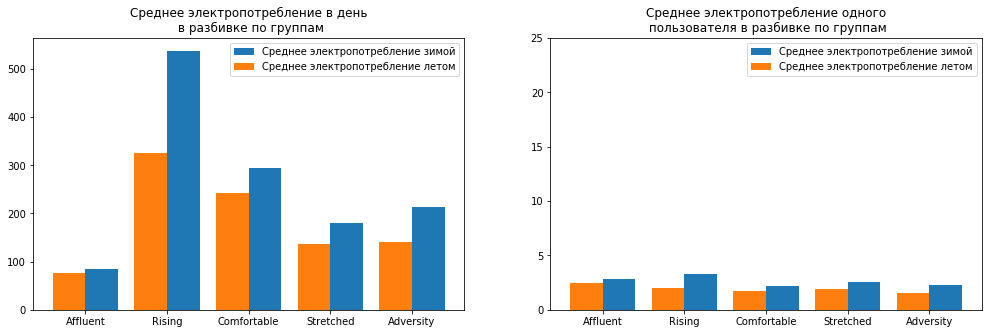

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(17,5))
axes[0].bar(x=data_electric_heating.index, height = data_electric_heating['winter_mean'], 
            width = 0.4, align = 'edge', label = 'Среднее электропотребление зимой')
axes[0].bar(x=data_electric_heating.index, height = data_electric_heating['summer_mean'], 
            width = -0.4, align = 'edge', label = 'Среднее электропотребление летом')
axes[0].legend(loc = 1)
axes[0].set_title('Среднее электропотребление в день\n в разбивке по группам');

axes[1].bar(x=data_electric_heating.index, height = data_electric_heating['winter_mean']/data_electric_heating['total_houses'], 
            width = 0.4, align = 'edge', label = 'Среднее электропотребление зимой')
axes[1].bar(x=data_electric_heating.index, height = data_electric_heating['summer_mean']/data_electric_heating['total_houses'], 
            width = -0.4, align = 'edge', label = 'Среднее электропотребление летом')
axes[1].legend(loc = 1)
axes[1].set_title('Среднее электропотребление одного\n пользователя в разбивке по группам');
axes[1].set_ylim(0, 25);

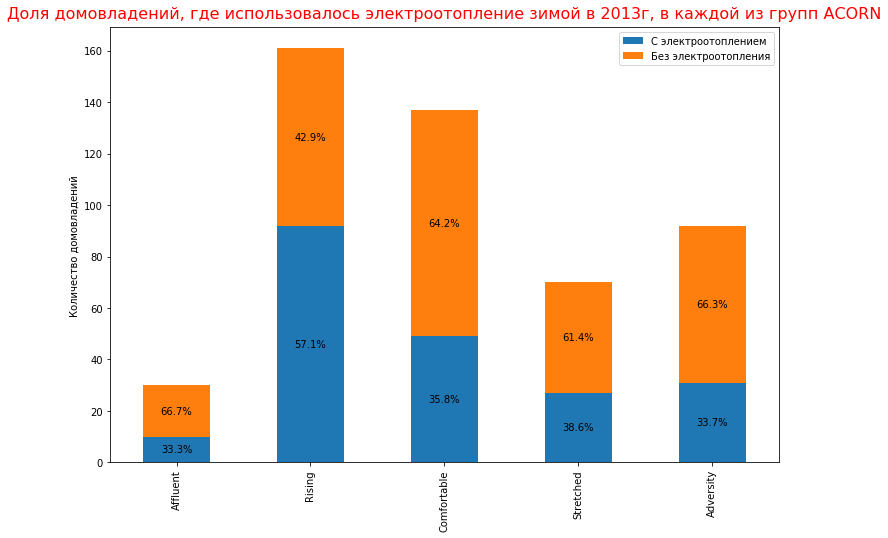

In [151]:
fig,ax=plt.subplots(figsize=(12,8))
ax.set_ylabel('Количество домовладений')
ax.set_title('Доля домовладений, где использовалось электроотопление зимой в 2013г, в каждой из групп ACORN', color = 'red', size = 16, verticalalignment='bottom');
print_percent(ax, data_electric_heating[['houses', 'less_heating']], data_electric_heating['total_houses'])
data_electric_heating[['houses', 'less_heating']].plot(ax=ax, kind='bar', stacked=True);
ax.legend(['С электроотоплением','Без электроотопления'])
ax.set_xlabel('');

#### Вывод:
- *Судя по полученным результатам, нельзя сделать однозначных выводов о зависимости между уровнем благосостояния (по классификации ACORN) и использованием электроэнергии для отопления жилых помещений в зимний сезон*
- *Тем не менее можно констатировать, что имеются две группы, где число домовладений, использующих электроэнергию для отопления зимой, существенно больше чем в других группах. Эти домовладения относятся к наиболее состоятельным.*

# 4. Итоговые выводы



В данном проекте на выборке из показаний электросчетчиков 5566 домовладений Лондона (Великобритания), с ноября 2011 по февраль 2014, мы исследовали влияние различных факторов (погодных, социальных, экономических) на уровень потребления электрической энергии.

В первой и второй части работы мы нормировали выборку отбросив наборы:
- с неполными данными: 
    - малое число показаний счетчиков в течении суток 
    - малое количество дней в году, когда проводились измерения потребления энергии 
- с данными от домовладений не имеющих общих критериев оценки факторов потребления электроэнергии с остальными домовладениями: общественные домовладения (не являющиеся жильем) 
- определили как оптимальный период для исследования - один календарный год - 2013
- учитывая ограниченность вычислительных ресурсов, для исследования мы использовали только часть нормированной выборки, взяв из нее определенный % домовладений из каждой группы (Acorn)


В третьей части работы мы исследовали влияние на уровень энергопотребления следующих факторов:
- среднесуточной температуры
- выходных/праздничных и рабочих дней
- длины светового дня
- времени суток и дня недели в течении года
- выбранного тарифного плана



### По результатам проведенного исследования мы пришли к следующим основным выводам:

- наибольшее влияние (до 70%) на динамику потребления электрической энергии оказывают два фактора
    - продолжительность светового дня
    - среднесуточная температура 
- следующий по значимости фактор, оказывающий влияние (до 50%) на средние значение потребления энергии в расчете на одно домовладение - это принадлежность к определенной группе (Acorn), определяемая уровнем благосостояния. Чем этот уровень выше - тем больше энергопотребление.
- значительного влияния (больше 2-10%) остальных факторов на динамику энергопотребления установить не удалось


При  исследовании зависимости суммарного потребления энергии в течении года от времени суток (от дня недели) мы  использовали качественную оценку динамики энергопотребления с помощью тепловых карт. Тепловые карты наглядно иллюстрируют нам следующие факты:
- самое большое потребление электроэнергии в течении года происходит в вечерние часы с 17:00 24:00
- на втором месте по потреблению дневные часы с 9:00 до 17:00
- пиковые значения приходятся на часы с 18:30 до 22:00 в период с конца октября по начало апреля
- в период с октября по апрель энергопотребление выше в течении всей недели, и незначительно увеличивается в выходные дни

##### Дополнительно мы подробно исследовали зависимость потребления энергии от среднесуточных температур наружного воздуха в течении года: 
- У нас получилась регрессионная модель зависимости потребления энергии от наружной температуры в зимний период и прямая в летний период; 
- Проведя расчет корреляции и коэффициента детерминации (его значение выше 0.8) мы доказали высокую зависимость этих величин; 
- Основываясь на этом факте мы сделали предположение и доказали факт использования электроэнергии для отопления части домовладений в зимний период;
- Мы посчитали долю домовладений в каждой из групп, использующих зимой электроэнергию для отопления. Доля таких домовладения составила от 57% до 33%.